In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t-10, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [11]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        print(df.shape)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [13]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [14]:
'''# Handling outlier, (if there are)
# New version
def handler_cm(cm_beUsed, time_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(0, len(cm_beUsed)-1):
        gradient = (cm_beUsed[i+1]-cm_beUsed[i])/(time_beUsed[i+1]-time_beUsed[i])
        if np.abs(gradient) > 55:
            cm_beUsed[i] = cm_beUsed[i+2*period] 
            cm_beUsed[i] = gradient*time_beUsed[i+1] + cm_beUsed[i+1]
            
    return cm_beUsed'''

'# Handling outlier, (if there are)\n# New version\ndef handler_cm(cm_beUsed, time_beUsed):\n    period = int(len(cm_beUsed) / 5)\n    for i in range(0, len(cm_beUsed)-1):\n        gradient = (cm_beUsed[i+1]-cm_beUsed[i])/(time_beUsed[i+1]-time_beUsed[i])\n        if np.abs(gradient) > 55:\n            cm_beUsed[i] = cm_beUsed[i+2*period] \n            cm_beUsed[i] = gradient*time_beUsed[i+1] + cm_beUsed[i+1]\n            \n    return cm_beUsed'

In [15]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [16]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [17]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [18]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [19]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

(17587, 2)
(11210, 2)
(11161, 2)
(12668, 2)
(11525, 2)
(12900, 2)
(12088, 2)
(16037, 2)
(12449, 2)
(24941, 2)
(7643, 2)
(10952, 2)
(11919, 2)
(10753, 2)
(10792, 2)
(11199, 2)
Dimension - time and Cm:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - x:  (80000, 3)
Dimension - y:  (80000, 1)


In [31]:
x = x[:5000*2]
y = y[:5000*2]
cm = cm[:5000*2]
t = t[:5000*2]

In [32]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [33]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [34]:
x_train.shape

(6999, 3)

In [35]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [36]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257 

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [38]:
model_directory = "D:\\TrainedModels\\20221227_Case01_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [39]:
ckpt_name = model_directory + "20221227unsteadyPrediction_Case01MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-06,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=80, factor=0.5,
                                          min_delta = 1e-7, min_lr=1e-06, verbose=1)

In [40]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [41]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/6 [====>.........................] - ETA: 2s - loss: 0.7962 - rmse: 0.8922
Epoch 1: val_loss improved from inf to 0.03053, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 1s 54ms/step - loss: 0.3707 - rmse: 0.6088 - val_loss: 0.0305 - val_rmse: 0.1744 - lr: 1.0000e-04
Epoch 2/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0302 - rmse: 0.1736
Epoch 2: val_loss did not improve from 0.03053
6/6 [==============================] - 0s 14ms/step - loss: 0.0193 - rmse: 0.1384 - val_loss: 0.0480 - val_rmse: 0.2189 - lr: 1.0000e-04
Epoch 3/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.0478 - rmse: 0.2185
Epoch 3: val_loss improved from 0.03053 to 0.00576, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_

6/6 [==============================] - 0s 30ms/step - loss: 3.9527e-04 - rmse: 0.0171 - val_loss: 3.9601e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 24/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.0298e-04 - rmse: 0.0173
Epoch 24: val_loss did not improve from 0.00040
6/6 [==============================] - 0s 13ms/step - loss: 3.9652e-04 - rmse: 0.0172 - val_loss: 3.9683e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 25/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9686e-04 - rmse: 0.0172
Epoch 25: val_loss improved from 0.00040 to 0.00040, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 3.9680e-04 - rmse: 0.0172 - val_loss: 3.9571e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 26/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8331e-04 - rmse: 0.0168
Epoch 26: val_lo

Epoch 48/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9323e-04 - rmse: 0.0171
Epoch 48: val_loss did not improve from 0.00039
6/6 [==============================] - 0s 14ms/step - loss: 3.9279e-04 - rmse: 0.0171 - val_loss: 3.9400e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 49/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9883e-04 - rmse: 0.0173
Epoch 49: val_loss improved from 0.00039 to 0.00039, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 3.9252e-04 - rmse: 0.0171 - val_loss: 3.9371e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 50/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9853e-04 - rmse: 0.0173
Epoch 50: val_loss did not improve from 0.00039
6/6 [==============================] - 0s 14ms/step - loss: 3.9162e-04 - rmse: 0.0171 - val_loss: 3.9398e-04 - va

Epoch 72/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9278e-04 - rmse: 0.0172
Epoch 72: val_loss did not improve from 0.00039
6/6 [==============================] - 0s 13ms/step - loss: 3.8919e-04 - rmse: 0.0170 - val_loss: 3.9272e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 73/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9258e-04 - rmse: 0.0171
Epoch 73: val_loss improved from 0.00039 to 0.00039, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 3.9212e-04 - rmse: 0.0171 - val_loss: 3.8993e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 74/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8544e-04 - rmse: 0.0169
Epoch 74: val_loss did not improve from 0.00039
6/6 [==============================] - 0s 13ms/step - loss: 3.8968e-04 - rmse: 0.0171 - val_loss: 3.9104e-04 - va

6/6 [==============================] - 0s 24ms/step - loss: 3.8778e-04 - rmse: 0.0171 - val_loss: 3.8762e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 97/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9267e-04 - rmse: 0.0172
Epoch 97: val_loss did not improve from 0.00039
6/6 [==============================] - 0s 14ms/step - loss: 3.8354e-04 - rmse: 0.0169 - val_loss: 3.8775e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 98/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.9085e-04 - rmse: 0.0172
Epoch 98: val_loss improved from 0.00039 to 0.00039, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 3.8707e-04 - rmse: 0.0171 - val_loss: 3.8747e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 99/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8097e-04 - rmse: 0.0169
Epoch 99: val_lo

1/6 [====>.........................] - ETA: 0s - loss: 3.7980e-04 - rmse: 0.0169
Epoch 120: val_loss did not improve from 0.00038
6/6 [==============================] - 0s 13ms/step - loss: 3.8306e-04 - rmse: 0.0170 - val_loss: 3.8458e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 121/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8388e-04 - rmse: 0.0170
Epoch 121: val_loss did not improve from 0.00038
6/6 [==============================] - 0s 13ms/step - loss: 3.8149e-04 - rmse: 0.0170 - val_loss: 3.8438e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 122/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8362e-04 - rmse: 0.0170
Epoch 122: val_loss did not improve from 0.00038
6/6 [==============================] - 0s 13ms/step - loss: 3.8418e-04 - rmse: 0.0170 - val_loss: 3.8433e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 123/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8038e-04 - rmse: 0.0169
Epoch 123: val_loss improved from 0.00038 to 0

Epoch 144/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8315e-04 - rmse: 0.0171
Epoch 144: val_loss did not improve from 0.00038
6/6 [==============================] - 0s 14ms/step - loss: 3.8038e-04 - rmse: 0.0170 - val_loss: 3.8317e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 145/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7779e-04 - rmse: 0.0169
Epoch 145: val_loss improved from 0.00038 to 0.00038, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 3.7942e-04 - rmse: 0.0170 - val_loss: 3.8016e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 146/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8291e-04 - rmse: 0.0171
Epoch 146: val_loss did not improve from 0.00038
6/6 [==============================] - 0s 13ms/step - loss: 3.8150e-04 - rmse: 0.0170 - val_loss: 3.8073e-0

Epoch 169/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6992e-04 - rmse: 0.0167
Epoch 169: val_loss did not improve from 0.00038
6/6 [==============================] - 0s 13ms/step - loss: 3.7742e-04 - rmse: 0.0170 - val_loss: 3.7854e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 170/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6910e-04 - rmse: 0.0167
Epoch 170: val_loss did not improve from 0.00038
6/6 [==============================] - 0s 13ms/step - loss: 3.7531e-04 - rmse: 0.0169 - val_loss: 3.7769e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 171/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7686e-04 - rmse: 0.0170
Epoch 171: val_loss improved from 0.00038 to 0.00038, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 3.7736e-04 - rmse: 0.0170 - val_loss: 3.7616e-0

Epoch 193/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6300e-04 - rmse: 0.0166
Epoch 193: val_loss improved from 0.00037 to 0.00037, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 3.7353e-04 - rmse: 0.0169 - val_loss: 3.7297e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 194/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6960e-04 - rmse: 0.0168
Epoch 194: val_loss did not improve from 0.00037
6/6 [==============================] - 0s 13ms/step - loss: 3.7130e-04 - rmse: 0.0169 - val_loss: 3.7801e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 195/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.8216e-04 - rmse: 0.0172
Epoch 195: val_loss did not improve from 0.00037
6/6 [==============================] - 0s 14ms/step - loss: 3.7354e-04 - rmse: 0.0169 - val_loss: 3.7340e-0

Epoch 217/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7330e-04 - rmse: 0.0170
Epoch 217: val_loss improved from 0.00037 to 0.00037, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 3.7182e-04 - rmse: 0.0169 - val_loss: 3.6846e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 218/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7378e-04 - rmse: 0.0170
Epoch 218: val_loss improved from 0.00037 to 0.00037, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 3.7013e-04 - rmse: 0.0169 - val_loss: 3.6833e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 219/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6283e-04 - rmse

6/6 [==============================] - 0s 27ms/step - loss: 3.7063e-04 - rmse: 0.0170 - val_loss: 3.6472e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 241/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.7502e-04 - rmse: 0.0171
Epoch 241: val_loss did not improve from 0.00036
6/6 [==============================] - 0s 14ms/step - loss: 3.6702e-04 - rmse: 0.0169 - val_loss: 3.6481e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 242/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5964e-04 - rmse: 0.0166
Epoch 242: val_loss did not improve from 0.00036
6/6 [==============================] - 0s 14ms/step - loss: 3.6667e-04 - rmse: 0.0169 - val_loss: 3.6533e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 243/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6444e-04 - rmse: 0.0168
Epoch 243: val_loss did not improve from 0.00036
6/6 [==============================] - 0s 13ms/step - loss: 3.6112e-04 - rmse: 0.0167 - val_loss: 3.6728e-04 - val_rmse: 0.0169

Epoch 264/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4969e-04 - rmse: 0.0164
Epoch 264: val_loss improved from 0.00036 to 0.00036, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 30ms/step - loss: 3.6201e-04 - rmse: 0.0168 - val_loss: 3.6040e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 265/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6116e-04 - rmse: 0.0168
Epoch 265: val_loss did not improve from 0.00036
6/6 [==============================] - 0s 13ms/step - loss: 3.6228e-04 - rmse: 0.0168 - val_loss: 3.6223e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 266/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6506e-04 - rmse: 0.0169
Epoch 266: val_loss did not improve from 0.00036
6/6 [==============================] - 0s 13ms/step - loss: 3.5802e-04 - rmse: 0.0167 - val_loss: 3.6377e-0

Epoch 288/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6065e-04 - rmse: 0.0168
Epoch 288: val_loss did not improve from 0.00036
6/6 [==============================] - 0s 14ms/step - loss: 3.5697e-04 - rmse: 0.0167 - val_loss: 3.5885e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 289/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5179e-04 - rmse: 0.0165
Epoch 289: val_loss did not improve from 0.00036
6/6 [==============================] - 0s 13ms/step - loss: 3.5598e-04 - rmse: 0.0167 - val_loss: 3.5778e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 290/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5509e-04 - rmse: 0.0166
Epoch 290: val_loss did not improve from 0.00036
6/6 [==============================] - 0s 13ms/step - loss: 3.5385e-04 - rmse: 0.0166 - val_loss: 3.6663e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 291/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6542e-04 - rmse: 0.0169
Epoch 291: val_loss did not im

1/6 [====>.........................] - ETA: 0s - loss: 3.6034e-04 - rmse: 0.0169
Epoch 312: val_loss improved from 0.00035 to 0.00035, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 3.5382e-04 - rmse: 0.0167 - val_loss: 3.5268e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 313/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4368e-04 - rmse: 0.0164
Epoch 313: val_loss did not improve from 0.00035
6/6 [==============================] - 0s 14ms/step - loss: 3.5156e-04 - rmse: 0.0166 - val_loss: 3.5294e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 314/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.6067e-04 - rmse: 0.0169
Epoch 314: val_loss did not improve from 0.00035
6/6 [==============================] - 0s 13ms/step - loss: 3.5664e-04 - rmse: 0.0167 - val_loss: 3.5438e-04 - val_rmse: 0.

6/6 [==============================] - 0s 24ms/step - loss: 3.5133e-04 - rmse: 0.0166 - val_loss: 3.4836e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 335/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5434e-04 - rmse: 0.0167
Epoch 335: val_loss improved from 0.00035 to 0.00035, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 3.4681e-04 - rmse: 0.0165 - val_loss: 3.4820e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 336/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.5439e-04 - rmse: 0.0167
Epoch 336: val_loss did not improve from 0.00035
6/6 [==============================] - 0s 13ms/step - loss: 3.5027e-04 - rmse: 0.0166 - val_loss: 3.4871e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 337/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4583e-04 - rmse: 0.0165
Epoch 337: 

1/6 [====>.........................] - ETA: 0s - loss: 3.4822e-04 - rmse: 0.0166
Epoch 358: val_loss did not improve from 0.00034
6/6 [==============================] - 0s 13ms/step - loss: 3.4392e-04 - rmse: 0.0165 - val_loss: 3.4802e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 359/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4552e-04 - rmse: 0.0165
Epoch 359: val_loss did not improve from 0.00034
6/6 [==============================] - 0s 13ms/step - loss: 3.4256e-04 - rmse: 0.0164 - val_loss: 3.4692e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 360/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4875e-04 - rmse: 0.0166
Epoch 360: val_loss improved from 0.00034 to 0.00034, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 3.4386e-04 - rmse: 0.0165 - val_loss: 3.4352e-04 - val_rmse: 0.

6/6 [==============================] - 0s 27ms/step - loss: 3.4268e-04 - rmse: 0.0165 - val_loss: 3.3929e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 383/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3794e-04 - rmse: 0.0163
Epoch 383: val_loss did not improve from 0.00034
6/6 [==============================] - 0s 14ms/step - loss: 3.4197e-04 - rmse: 0.0165 - val_loss: 3.3956e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 384/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3751e-04 - rmse: 0.0163
Epoch 384: val_loss improved from 0.00034 to 0.00034, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 28ms/step - loss: 3.3741e-04 - rmse: 0.0163 - val_loss: 3.3862e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 385/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.4718e-04 - rmse: 0.0166
Epoch 385: 

6/6 [==============================] - 0s 13ms/step - loss: 3.3701e-04 - rmse: 0.0164 - val_loss: 3.3998e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 405/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3200e-04 - rmse: 0.0162
Epoch 405: val_loss did not improve from 0.00034
6/6 [==============================] - 0s 13ms/step - loss: 3.3592e-04 - rmse: 0.0163 - val_loss: 3.3823e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 406/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3689e-04 - rmse: 0.0164
Epoch 406: val_loss did not improve from 0.00034
6/6 [==============================] - 0s 13ms/step - loss: 3.3504e-04 - rmse: 0.0163 - val_loss: 3.3600e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 407/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.2868e-04 - rmse: 0.0161
Epoch 407: val_loss did not improve from 0.00034
6/6 [==============================] - 0s 13ms/step - loss: 3.3459e-04 - rmse: 0.0163 - val_loss: 3.3883e-04 - val_rmse: 0.0164

6/6 [==============================] - 0s 29ms/step - loss: 3.2963e-04 - rmse: 0.0162 - val_loss: 3.3037e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 428/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.2236e-04 - rmse: 0.0160
Epoch 428: val_loss did not improve from 0.00033
6/6 [==============================] - 0s 13ms/step - loss: 3.3179e-04 - rmse: 0.0163 - val_loss: 3.3096e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 429/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.2966e-04 - rmse: 0.0162
Epoch 429: val_loss improved from 0.00033 to 0.00033, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 30ms/step - loss: 3.3258e-04 - rmse: 0.0163 - val_loss: 3.3010e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 430/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.2800e-04 - rmse: 0.0161
Epoch 430: 

Epoch 452/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.1542e-04 - rmse: 0.0158
Epoch 452: val_loss did not improve from 0.00033
6/6 [==============================] - 0s 13ms/step - loss: 3.1959e-04 - rmse: 0.0159 - val_loss: 3.2615e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 453/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3035e-04 - rmse: 0.0163
Epoch 453: val_loss improved from 0.00033 to 0.00032, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 3.2705e-04 - rmse: 0.0162 - val_loss: 3.2490e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 454/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.2974e-04 - rmse: 0.0163
Epoch 454: val_loss did not improve from 0.00032
6/6 [==============================] - 0s 13ms/step - loss: 3.2727e-04 - rmse: 0.0162 - val_loss: 3.2535e-0

Epoch 476/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.2803e-04 - rmse: 0.0162
Epoch 476: val_loss improved from 0.00032 to 0.00032, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 3.2468e-04 - rmse: 0.0161 - val_loss: 3.2023e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 477/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.2666e-04 - rmse: 0.0162
Epoch 477: val_loss did not improve from 0.00032
6/6 [==============================] - 0s 13ms/step - loss: 3.2357e-04 - rmse: 0.0161 - val_loss: 3.3404e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 478/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.3416e-04 - rmse: 0.0164
Epoch 478: val_loss did not improve from 0.00032
6/6 [==============================] - 0s 13ms/step - loss: 3.2412e-04 - rmse: 0.0161 - val_loss: 3.2112e-0

1/6 [====>.........................] - ETA: 0s - loss: 3.1262e-04 - rmse: 0.0158
Epoch 501: val_loss improved from 0.00032 to 0.00031, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 3.1695e-04 - rmse: 0.0160 - val_loss: 3.1401e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 502/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.0712e-04 - rmse: 0.0156
Epoch 502: val_loss did not improve from 0.00031
6/6 [==============================] - 0s 13ms/step - loss: 3.1512e-04 - rmse: 0.0159 - val_loss: 3.1506e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 503/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.1894e-04 - rmse: 0.0160
Epoch 503: val_loss did not improve from 0.00031
6/6 [==============================] - 0s 13ms/step - loss: 3.1526e-04 - rmse: 0.0159 - val_loss: 3.2063e-04 - val_rmse: 0.

1/6 [====>.........................] - ETA: 0s - loss: 3.2094e-04 - rmse: 0.0161
Epoch 525: val_loss did not improve from 0.00031
6/6 [==============================] - 0s 14ms/step - loss: 3.1196e-04 - rmse: 0.0158 - val_loss: 3.0877e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 526/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.1460e-04 - rmse: 0.0159
Epoch 526: val_loss did not improve from 0.00031
6/6 [==============================] - 0s 13ms/step - loss: 3.1205e-04 - rmse: 0.0158 - val_loss: 3.1541e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 527/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.0193e-04 - rmse: 0.0155
Epoch 527: val_loss did not improve from 0.00031
6/6 [==============================] - 0s 13ms/step - loss: 3.0835e-04 - rmse: 0.0157 - val_loss: 3.1179e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 528/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.1386e-04 - rmse: 0.0159
Epoch 528: val_loss did not improve from 0.000

1/6 [====>.........................] - ETA: 0s - loss: 3.0553e-04 - rmse: 0.0157
Epoch 549: val_loss did not improve from 0.00030
6/6 [==============================] - 0s 13ms/step - loss: 3.0496e-04 - rmse: 0.0157 - val_loss: 3.1260e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 550/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.0490e-04 - rmse: 0.0157
Epoch 550: val_loss did not improve from 0.00030
6/6 [==============================] - 0s 13ms/step - loss: 3.1054e-04 - rmse: 0.0158 - val_loss: 3.0354e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 551/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.0496e-04 - rmse: 0.0157
Epoch 551: val_loss improved from 0.00030 to 0.00030, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 3.0225e-04 - rmse: 0.0156 - val_loss: 3.0300e-04 - val_rmse: 0.

Epoch 572/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.9721e-04 - rmse: 0.0155
Epoch 572: val_loss improved from 0.00030 to 0.00030, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 3.0023e-04 - rmse: 0.0156 - val_loss: 2.9718e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 573/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.9185e-04 - rmse: 0.0153
Epoch 573: val_loss did not improve from 0.00030
6/6 [==============================] - 0s 13ms/step - loss: 2.9404e-04 - rmse: 0.0154 - val_loss: 2.9740e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 574/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.9554e-04 - rmse: 0.0154
Epoch 574: val_loss did not improve from 0.00030
6/6 [==============================] - 0s 13ms/step - loss: 2.9895e-04 - rmse: 0.0155 - val_loss: 3.0208e-0

Epoch 597/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8575e-04 - rmse: 0.0151
Epoch 597: val_loss did not improve from 0.00029
6/6 [==============================] - 0s 14ms/step - loss: 2.9293e-04 - rmse: 0.0154 - val_loss: 2.9664e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 598/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8700e-04 - rmse: 0.0152
Epoch 598: val_loss improved from 0.00029 to 0.00029, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 28ms/step - loss: 2.8871e-04 - rmse: 0.0152 - val_loss: 2.9061e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 599/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8464e-04 - rmse: 0.0151
Epoch 599: val_loss did not improve from 0.00029
6/6 [==============================] - 0s 13ms/step - loss: 2.9387e-04 - rmse: 0.0154 - val_loss: 2.9084e-0

Epoch 622/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.9208e-04 - rmse: 0.0154
Epoch 622: val_loss improved from 0.00029 to 0.00028, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 2.8908e-04 - rmse: 0.0153 - val_loss: 2.8470e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 623/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8273e-04 - rmse: 0.0151
Epoch 623: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 13ms/step - loss: 2.9010e-04 - rmse: 0.0153 - val_loss: 2.8628e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 624/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.9397e-04 - rmse: 0.0154
Epoch 624: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 14ms/step - loss: 2.8358e-04 - rmse: 0.0151 - val_loss: 2.8509e-0

6/6 [==============================] - 0s 32ms/step - loss: 2.8012e-04 - rmse: 0.0150 - val_loss: 2.7739e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 646/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.7649e-04 - rmse: 0.0149
Epoch 646: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 14ms/step - loss: 2.7658e-04 - rmse: 0.0149 - val_loss: 2.7800e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 647/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8127e-04 - rmse: 0.0151
Epoch 647: val_loss did not improve from 0.00028
6/6 [==============================] - 0s 13ms/step - loss: 2.7647e-04 - rmse: 0.0149 - val_loss: 2.8220e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 648/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8325e-04 - rmse: 0.0151
Epoch 648: val_loss improved from 0.00028 to 0.00028, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers

1/6 [====>.........................] - ETA: 0s - loss: 2.6345e-04 - rmse: 0.0145
Epoch 670: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 14ms/step - loss: 2.7105e-04 - rmse: 0.0148 - val_loss: 2.7509e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 671/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.7802e-04 - rmse: 0.0150
Epoch 671: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 14ms/step - loss: 2.7242e-04 - rmse: 0.0148 - val_loss: 2.7709e-04 - val_rmse: 0.0150 - lr: 1.0000e-04
Epoch 672/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8999e-04 - rmse: 0.0154
Epoch 672: val_loss did not improve from 0.00027
6/6 [==============================] - 0s 14ms/step - loss: 2.7263e-04 - rmse: 0.0148 - val_loss: 2.7993e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 673/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8073e-04 - rmse: 0.0151
Epoch 673: val_loss improved from 0.00027 to 0

1/6 [====>.........................] - ETA: 0s - loss: 2.6156e-04 - rmse: 0.0145
Epoch 694: val_loss did not improve from 0.00026
6/6 [==============================] - 0s 13ms/step - loss: 2.6958e-04 - rmse: 0.0147 - val_loss: 2.6527e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 695/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.6292e-04 - rmse: 0.0145
Epoch 695: val_loss did not improve from 0.00026
6/6 [==============================] - 0s 13ms/step - loss: 2.6410e-04 - rmse: 0.0146 - val_loss: 2.6518e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 696/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.6462e-04 - rmse: 0.0146
Epoch 696: val_loss did not improve from 0.00026
6/6 [==============================] - 0s 13ms/step - loss: 2.7155e-04 - rmse: 0.0148 - val_loss: 2.7043e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 697/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.6990e-04 - rmse: 0.0148
Epoch 697: val_loss improved from 0.00026 to 0

1/6 [====>.........................] - ETA: 0s - loss: 2.9344e-04 - rmse: 0.0156
Epoch 718: val_loss did not improve from 0.00026
6/6 [==============================] - 0s 13ms/step - loss: 2.6655e-04 - rmse: 0.0147 - val_loss: 2.5875e-04 - val_rmse: 0.0144 - lr: 1.0000e-04
Epoch 719/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.5789e-04 - rmse: 0.0144
Epoch 719: val_loss improved from 0.00026 to 0.00026, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 2.6138e-04 - rmse: 0.0145 - val_loss: 2.5613e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 720/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.5719e-04 - rmse: 0.0143
Epoch 720: val_loss did not improve from 0.00026
6/6 [==============================] - 0s 13ms/step - loss: 2.6236e-04 - rmse: 0.0145 - val_loss: 2.5923e-04 - val_rmse: 0.

Epoch 742/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.5125e-04 - rmse: 0.0142
Epoch 742: val_loss did not improve from 0.00025
6/6 [==============================] - 0s 14ms/step - loss: 2.4782e-04 - rmse: 0.0141 - val_loss: 2.4779e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 743/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.4727e-04 - rmse: 0.0140
Epoch 743: val_loss did not improve from 0.00025
6/6 [==============================] - 0s 13ms/step - loss: 2.5600e-04 - rmse: 0.0143 - val_loss: 2.5556e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 744/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.6554e-04 - rmse: 0.0147
Epoch 744: val_loss did not improve from 0.00025
6/6 [==============================] - 0s 13ms/step - loss: 2.5307e-04 - rmse: 0.0142 - val_loss: 2.6289e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 745/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.7929e-04 - rmse: 0.0151
Epoch 745: val_loss improved f

Epoch 767/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.3973e-04 - rmse: 0.0138
Epoch 767: val_loss improved from 0.00024 to 0.00024, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 2.5469e-04 - rmse: 0.0143 - val_loss: 2.3830e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 768/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.3977e-04 - rmse: 0.0138
Epoch 768: val_loss did not improve from 0.00024
6/6 [==============================] - 0s 13ms/step - loss: 2.4235e-04 - rmse: 0.0139 - val_loss: 2.5078e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 769/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.5860e-04 - rmse: 0.0145
Epoch 769: val_loss did not improve from 0.00024
6/6 [==============================] - 0s 13ms/step - loss: 2.4814e-04 - rmse: 0.0141 - val_loss: 2.4460e-0

6/6 [==============================] - 0s 13ms/step - loss: 2.4308e-04 - rmse: 0.0139 - val_loss: 2.9147e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 794/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.8049e-04 - rmse: 0.0152
Epoch 794: val_loss did not improve from 0.00023
6/6 [==============================] - 0s 13ms/step - loss: 2.5560e-04 - rmse: 0.0144 - val_loss: 2.9645e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 795/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.9584e-04 - rmse: 0.0157
Epoch 795: val_loss did not improve from 0.00023
6/6 [==============================] - 0s 13ms/step - loss: 2.5775e-04 - rmse: 0.0145 - val_loss: 2.5210e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 796/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.4944e-04 - rmse: 0.0142
Epoch 796: val_loss improved from 0.00023 to 0.00023, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers

Epoch 818/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.2640e-04 - rmse: 0.0134
Epoch 818: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 2.2845e-04 - rmse: 0.0134 - val_loss: 2.2261e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 819/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.2117e-04 - rmse: 0.0132
Epoch 819: val_loss did not improve from 0.00022
6/6 [==============================] - 0s 13ms/step - loss: 2.2650e-04 - rmse: 0.0134 - val_loss: 2.2292e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 820/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.2085e-04 - rmse: 0.0132
Epoch 820: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val

1/6 [====>.........................] - ETA: 0s - loss: 2.5089e-04 - rmse: 0.0143
Epoch 842: val_loss improved from 0.00022 to 0.00022, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 2.3085e-04 - rmse: 0.0136 - val_loss: 2.1522e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 843/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.1753e-04 - rmse: 0.0131
Epoch 843: val_loss did not improve from 0.00022
6/6 [==============================] - 0s 13ms/step - loss: 2.3359e-04 - rmse: 0.0137 - val_loss: 2.1542e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 844/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.1456e-04 - rmse: 0.0130
Epoch 844: val_loss did not improve from 0.00022
6/6 [==============================] - 0s 13ms/step - loss: 2.1455e-04 - rmse: 0.0130 - val_loss: 2.1732e-04 - val_rmse: 0.

Epoch 868/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.3944e-04 - rmse: 0.0139
Epoch 868: val_loss did not improve from 0.00021
6/6 [==============================] - 0s 13ms/step - loss: 2.2395e-04 - rmse: 0.0133 - val_loss: 2.2253e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 869/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.1078e-04 - rmse: 0.0128
Epoch 869: val_loss did not improve from 0.00021
6/6 [==============================] - 0s 13ms/step - loss: 2.1994e-04 - rmse: 0.0132 - val_loss: 2.2148e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 870/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.3077e-04 - rmse: 0.0136
Epoch 870: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 2.1303e-04 - rmse: 0.0129 - val_loss: 2.0742e-0

1/6 [====>.........................] - ETA: 0s - loss: 2.7591e-04 - rmse: 0.0152
Epoch 892: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 2.2787e-04 - rmse: 0.0135 - val_loss: 1.9919e-04 - val_rmse: 0.0124 - lr: 1.0000e-04
Epoch 893/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.0561e-04 - rmse: 0.0127
Epoch 893: val_loss did not improve from 0.00020
6/6 [==============================] - 0s 13ms/step - loss: 2.1292e-04 - rmse: 0.0129 - val_loss: 2.1266e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 894/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.0213e-04 - rmse: 0.0125
Epoch 894: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5la

6/6 [==============================] - 0s 13ms/step - loss: 2.8905e-04 - rmse: 0.0156 - val_loss: 2.6335e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 918/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.4523e-04 - rmse: 0.0142
Epoch 918: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 2.5818e-04 - rmse: 0.0146 - val_loss: 1.9298e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 919/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.9163e-04 - rmse: 0.0121
Epoch 919: val_loss did not improve from 0.00019
6/6 [==============================] - 0s 13ms/step - loss: 2.2147e-04 - rmse: 0.0133 - val_loss: 1.9301e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 920/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8769e-04 - rmse: 0.0120
Epoch 920: 

6/6 [==============================] - 0s 13ms/step - loss: 1.8641e-04 - rmse: 0.0119 - val_loss: 2.0343e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 940/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.0061e-04 - rmse: 0.0125
Epoch 940: val_loss did not improve from 0.00019
6/6 [==============================] - 0s 13ms/step - loss: 1.9451e-04 - rmse: 0.0123 - val_loss: 1.8701e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 941/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8963e-04 - rmse: 0.0121
Epoch 941: val_loss improved from 0.00019 to 0.00019, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 1.8844e-04 - rmse: 0.0120 - val_loss: 1.8564e-04 - val_rmse: 0.0119 - lr: 1.0000e-04
Epoch 942/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8393e-04 - rmse: 0.0118
Epoch 942: 

Epoch 964/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.7820e-04 - rmse: 0.0116
Epoch 964: val_loss did not improve from 0.00018
6/6 [==============================] - 0s 13ms/step - loss: 1.7964e-04 - rmse: 0.0117 - val_loss: 2.0331e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 965/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.9694e-04 - rmse: 0.0124
Epoch 965: val_loss did not improve from 0.00018
6/6 [==============================] - 0s 13ms/step - loss: 2.0251e-04 - rmse: 0.0126 - val_loss: 2.3337e-04 - val_rmse: 0.0138 - lr: 1.0000e-04
Epoch 966/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.4269e-04 - rmse: 0.0141
Epoch 966: val_loss did not improve from 0.00018
6/6 [==============================] - 0s 13ms/step - loss: 2.5143e-04 - rmse: 0.0144 - val_loss: 2.7346e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 967/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.6429e-04 - rmse: 0.0149
Epoch 967: val_loss did not im

1/6 [====>.........................] - ETA: 0s - loss: 1.8312e-04 - rmse: 0.0118
Epoch 989: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 29ms/step - loss: 1.7454e-04 - rmse: 0.0115 - val_loss: 1.7306e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 990/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.7479e-04 - rmse: 0.0115
Epoch 990: val_loss did not improve from 0.00017
6/6 [==============================] - 0s 14ms/step - loss: 1.7138e-04 - rmse: 0.0113 - val_loss: 1.8018e-04 - val_rmse: 0.0117 - lr: 1.0000e-04
Epoch 991/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.7379e-04 - rmse: 0.0114
Epoch 991: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5la

6/6 [==============================] - 0s 13ms/step - loss: 1.8270e-04 - rmse: 0.0119 - val_loss: 2.0985e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 1016/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.9745e-04 - rmse: 0.0125
Epoch 1016: val_loss did not improve from 0.00017
6/6 [==============================] - 0s 13ms/step - loss: 2.0369e-04 - rmse: 0.0127 - val_loss: 2.6065e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 1017/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.7234e-04 - rmse: 0.0152
Epoch 1017: val_loss did not improve from 0.00017
6/6 [==============================] - 0s 13ms/step - loss: 2.3837e-04 - rmse: 0.0140 - val_loss: 2.4738e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 1018/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.3514e-04 - rmse: 0.0139
Epoch 1018: val_loss did not improve from 0.00017
6/6 [==============================] - 0s 13ms/step - loss: 2.0396e-04 - rmse: 0.0127 - val_loss: 1.7855e-04 - val_rmse: 

1/6 [====>.........................] - ETA: 0s - loss: 1.8086e-04 - rmse: 0.0118
Epoch 1041: val_loss did not improve from 0.00016
6/6 [==============================] - 0s 14ms/step - loss: 1.7299e-04 - rmse: 0.0115 - val_loss: 1.6012e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 1042/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.6580e-04 - rmse: 0.0111
Epoch 1042: val_loss did not improve from 0.00016
6/6 [==============================] - 0s 13ms/step - loss: 1.5948e-04 - rmse: 0.0109 - val_loss: 1.6736e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 1043/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.7230e-04 - rmse: 0.0114
Epoch 1043: val_loss did not improve from 0.00016
6/6 [==============================] - 0s 14ms/step - loss: 1.6930e-04 - rmse: 0.0113 - val_loss: 1.8664e-04 - val_rmse: 0.0120 - lr: 1.0000e-04
Epoch 1044/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8349e-04 - rmse: 0.0119
Epoch 1044: val_loss did not improve fro

Epoch 1067/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.9611e-04 - rmse: 0.0125
Epoch 1067: val_loss did not improve from 0.00015
6/6 [==============================] - 0s 13ms/step - loss: 2.0877e-04 - rmse: 0.0129 - val_loss: 1.5362e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 1068/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5182e-04 - rmse: 0.0105
Epoch 1068: val_loss did not improve from 0.00015
6/6 [==============================] - 0s 13ms/step - loss: 1.8163e-04 - rmse: 0.0119 - val_loss: 1.7082e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 1069/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.6967e-04 - rmse: 0.0113
Epoch 1069: val_loss did not improve from 0.00015
6/6 [==============================] - 0s 13ms/step - loss: 1.7692e-04 - rmse: 0.0117 - val_loss: 1.7498e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 1070/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.7548e-04 - rmse: 0.0116
Epoch 1070: val_loss di

Epoch 1092/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.6010e-04 - rmse: 0.0109
Epoch 1092: val_loss did not improve from 0.00015
6/6 [==============================] - 0s 14ms/step - loss: 1.5483e-04 - rmse: 0.0107 - val_loss: 1.5370e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 1093/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5254e-04 - rmse: 0.0106
Epoch 1093: val_loss did not improve from 0.00015
6/6 [==============================] - 0s 13ms/step - loss: 1.4955e-04 - rmse: 0.0104 - val_loss: 1.5122e-04 - val_rmse: 0.0105 - lr: 1.0000e-04
Epoch 1094/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5129e-04 - rmse: 0.0105
Epoch 1094: val_loss did not improve from 0.00015
6/6 [==============================] - 0s 13ms/step - loss: 1.5141e-04 - rmse: 0.0105 - val_loss: 1.7235e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 1095/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.6494e-04 - rmse: 0.0112
Epoch 1095: val_loss im

Epoch 1117/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.4543e-04 - rmse: 0.0103
Epoch 1117: val_loss did not improve from 0.00014
6/6 [==============================] - 0s 13ms/step - loss: 1.8395e-04 - rmse: 0.0120 - val_loss: 1.5240e-04 - val_rmse: 0.0106 - lr: 1.0000e-04
Epoch 1118/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5262e-04 - rmse: 0.0106
Epoch 1118: val_loss did not improve from 0.00014
6/6 [==============================] - 0s 13ms/step - loss: 1.6660e-04 - rmse: 0.0112 - val_loss: 1.7158e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 1119/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8163e-04 - rmse: 0.0119
Epoch 1119: val_loss did not improve from 0.00014
6/6 [==============================] - 0s 14ms/step - loss: 1.6343e-04 - rmse: 0.0111 - val_loss: 1.7527e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 1120/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5940e-04 - rmse: 0.0109
Epoch 1120: val_loss im

1/6 [====>.........................] - ETA: 0s - loss: 1.3901e-04 - rmse: 0.0100
Epoch 1143: val_loss did not improve from 0.00014
6/6 [==============================] - 0s 13ms/step - loss: 1.3881e-04 - rmse: 0.0100 - val_loss: 1.6772e-04 - val_rmse: 0.0113 - lr: 1.0000e-04
Epoch 1144/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8134e-04 - rmse: 0.0119
Epoch 1144: val_loss did not improve from 0.00014
6/6 [==============================] - 0s 13ms/step - loss: 1.7508e-04 - rmse: 0.0116 - val_loss: 2.7276e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 1145/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.6629e-04 - rmse: 0.0151
Epoch 1145: val_loss did not improve from 0.00014
6/6 [==============================] - 0s 13ms/step - loss: 1.9395e-04 - rmse: 0.0124 - val_loss: 1.7796e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1146/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.9101e-04 - rmse: 0.0123
Epoch 1146: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 1.6658e-04 - rmse: 0.0113
Epoch 1168: val_loss did not improve from 0.00013
6/6 [==============================] - 0s 13ms/step - loss: 1.7261e-04 - rmse: 0.0115 - val_loss: 1.6923e-04 - val_rmse: 0.0114 - lr: 1.0000e-04
Epoch 1169/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.6069e-04 - rmse: 0.0110
Epoch 1169: val_loss did not improve from 0.00013
6/6 [==============================] - 0s 14ms/step - loss: 1.7094e-04 - rmse: 0.0115 - val_loss: 2.1556e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 1170/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.3399e-04 - rmse: 0.0140
Epoch 1170: val_loss did not improve from 0.00013
6/6 [==============================] - 0s 13ms/step - loss: 2.0073e-04 - rmse: 0.0127 - val_loss: 2.4733e-04 - val_rmse: 0.0144 - lr: 1.0000e-04
Epoch 1171/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.3900e-04 - rmse: 0.0141
Epoch 1171: val_loss did not improve fro

Epoch 1195/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.3746e-04 - rmse: 0.0099
Epoch 1195: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 1.2627e-04 - rmse: 0.0094 - val_loss: 1.2582e-04 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 1196/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.2508e-04 - rmse: 0.0093
Epoch 1196: val_loss did not improve from 0.00013
6/6 [==============================] - 0s 13ms/step - loss: 1.4846e-04 - rmse: 0.0105 - val_loss: 1.8552e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 1197/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.9316e-04 - rmse: 0.0124
Epoch 1197: val_loss did not improve from 0.00013
6/6 [==============================] - 0s 13ms/step - loss: 1.4663e-04 - rmse: 0.0104 - val_loss: 1.5

1/6 [====>.........................] - ETA: 0s - loss: 1.2369e-04 - rmse: 0.0092
Epoch 1220: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 1.2232e-04 - rmse: 0.0092 - val_loss: 1.2086e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 1221/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1501e-04 - rmse: 0.0088
Epoch 1221: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 22ms/step - loss: 1.2409e-04 - rmse: 0.0093 - val_loss: 1.2048e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 1222/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1806e-04 - rmse: 0.0089
Epo

Epoch 1246/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1998e-04 - rmse: 0.0091
Epoch 1246: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 1.1772e-04 - rmse: 0.0089 - val_loss: 1.1639e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 1247/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1626e-04 - rmse: 0.0088
Epoch 1247: val_loss did not improve from 0.00012
6/6 [==============================] - 0s 13ms/step - loss: 1.2110e-04 - rmse: 0.0091 - val_loss: 1.4547e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 1248/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.4382e-04 - rmse: 0.0103
Epoch 1248: val_loss did not improve from 0.00012
6/6 [==============================] - 0s 14ms/step - loss: 1.2748e-04 - rmse: 0.0095 - val_loss: 1.2

Epoch 1272/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8685e-04 - rmse: 0.0122
Epoch 1272: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 2.1000e-04 - rmse: 0.0131 - val_loss: 1.1286e-04 - val_rmse: 0.0087 - lr: 1.0000e-04
Epoch 1273/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1125e-04 - rmse: 0.0086
Epoch 1273: val_loss did not improve from 0.00011
6/6 [==============================] - 0s 13ms/step - loss: 1.2531e-04 - rmse: 0.0094 - val_loss: 1.1396e-04 - val_rmse: 0.0087 - lr: 1.0000e-04
Epoch 1274/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1563e-04 - rmse: 0.0088
Epoch 1274: val_loss did not improve from 0.00011
6/6 [==============================] - 0s 13ms/step - loss: 1.3969e-04 - rmse: 0.0101 - val_loss: 1.3

6/6 [==============================] - 0s 24ms/step - loss: 1.5241e-04 - rmse: 0.0107 - val_loss: 1.0940e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 1298/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1206e-04 - rmse: 0.0086
Epoch 1298: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 1.4787e-04 - rmse: 0.0105 - val_loss: 1.0897e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 1299/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0834e-04 - rmse: 0.0084
Epoch 1299: val_loss did not improve from 0.00011
6/6 [==============================] - 0s 13ms/step - loss: 1.3796e-04 - rmse: 0.0100 - val_loss: 1.2439e-04 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 1300/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.2156e-04 - rmse: 0.0092
Epoch 

Epoch 1324/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1736e-04 - rmse: 0.0090
Epoch 1324: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 1.3419e-04 - rmse: 0.0099 - val_loss: 1.0598e-04 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 1325/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0771e-04 - rmse: 0.0084
Epoch 1325: val_loss did not improve from 0.00011
6/6 [==============================] - 0s 13ms/step - loss: 1.0827e-04 - rmse: 0.0084 - val_loss: 1.0712e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 1326/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0390e-04 - rmse: 0.0082
Epoch 1326: val_loss did not improve from 0.00011
6/6 [==============================] - 0s 13ms/step - loss: 1.0536e-04 - rmse: 0.0083 - val_loss: 1.1

1/6 [====>.........................] - ETA: 0s - loss: 9.6967e-05 - rmse: 0.0078
Epoch 1348: val_loss did not improve from 0.00010
6/6 [==============================] - 0s 13ms/step - loss: 1.0172e-04 - rmse: 0.0081 - val_loss: 1.0882e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 1349/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0885e-04 - rmse: 0.0085
Epoch 1349: val_loss did not improve from 0.00010
6/6 [==============================] - 0s 14ms/step - loss: 1.1158e-04 - rmse: 0.0087 - val_loss: 1.8628e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 1350/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.7264e-04 - rmse: 0.0117
Epoch 1350: val_loss did not improve from 0.00010
6/6 [==============================] - 0s 13ms/step - loss: 1.7267e-04 - rmse: 0.0117 - val_loss: 1.1679e-04 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 1351/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1107e-04 - rmse: 0.0086
Epoch 1351: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 9.7939e-05 - rmse: 0.0078
Epoch 1373: val_loss did not improve from 0.00010
6/6 [==============================] - 0s 13ms/step - loss: 1.0475e-04 - rmse: 0.0083 - val_loss: 1.0808e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 1374/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0843e-04 - rmse: 0.0085
Epoch 1374: val_loss did not improve from 0.00010
6/6 [==============================] - 0s 14ms/step - loss: 1.4220e-04 - rmse: 0.0103 - val_loss: 1.0813e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 1375/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0787e-04 - rmse: 0.0085
Epoch 1375: val_loss did not improve from 0.00010
6/6 [==============================] - 0s 14ms/step - loss: 1.0764e-04 - rmse: 0.0084 - val_loss: 1.1958e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 1376/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0908e-04 - rmse: 0.0085
Epoch 1376: val_loss did not improve fro

6/6 [==============================] - 0s 14ms/step - loss: 1.0225e-04 - rmse: 0.0081 - val_loss: 1.0535e-04 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 1401/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.9155e-05 - rmse: 0.0079
Epoch 1401: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 30ms/step - loss: 9.8457e-05 - rmse: 0.0079 - val_loss: 9.7895e-05 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 1402/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.7551e-05 - rmse: 0.0078
Epoch 1402: val_loss did not improve from 0.00010
6/6 [==============================] - 0s 14ms/step - loss: 1.0268e-04 - rmse: 0.0082 - val_loss: 1.1558e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 1403/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1655e-04 - rmse: 0.0090
Epoch 

Epoch 1427/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0858e-04 - rmse: 0.0085
Epoch 1427: val_loss did not improve from 0.00010
6/6 [==============================] - 0s 13ms/step - loss: 1.0079e-04 - rmse: 0.0081 - val_loss: 9.5778e-05 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 1428/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.4925e-05 - rmse: 0.0077
Epoch 1428: val_loss improved from 0.00010 to 0.00009, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 9.6193e-05 - rmse: 0.0078 - val_loss: 9.4324e-05 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 1429/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.1740e-05 - rmse: 0.0075
Epoch 1429: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 14ms/step - loss: 1.0342e-04 - rmse: 0.0082 - val_loss: 9.7

1/6 [====>.........................] - ETA: 0s - loss: 1.5286e-04 - rmse: 0.0108
Epoch 1453: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 13ms/step - loss: 1.3487e-04 - rmse: 0.0100 - val_loss: 1.5286e-04 - val_rmse: 0.0108 - lr: 1.0000e-04
Epoch 1454/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5947e-04 - rmse: 0.0111
Epoch 1454: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 13ms/step - loss: 1.3407e-04 - rmse: 0.0099 - val_loss: 1.2298e-04 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 1455/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1463e-04 - rmse: 0.0089
Epoch 1455: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 14ms/step - loss: 1.1652e-04 - rmse: 0.0090 - val_loss: 9.6855e-05 - val_rmse: 0.0078 - lr: 1.0000e-04
Epoch 1456/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0009e-04 - rmse: 0.0080
Epoch 1456: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 1.8171e-04 - rmse: 0.0121
Epoch 1479: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 13ms/step - loss: 1.3228e-04 - rmse: 0.0098 - val_loss: 9.8656e-05 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 1480/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.7785e-05 - rmse: 0.0079
Epoch 1480: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 14ms/step - loss: 9.4227e-05 - rmse: 0.0077 - val_loss: 1.0388e-04 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 1481/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.8146e-05 - rmse: 0.0079
Epoch 1481: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 13ms/step - loss: 9.4684e-05 - rmse: 0.0077 - val_loss: 9.2599e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 1482/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.7076e-05 - rmse: 0.0072
Epoch 1482: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 9.0168e-05 - rmse: 0.0074
Epoch 1505: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 13ms/step - loss: 8.8084e-05 - rmse: 0.0073 - val_loss: 9.1331e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 1506/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.4728e-05 - rmse: 0.0070
Epoch 1506: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 23ms/step - loss: 8.8133e-05 - rmse: 0.0073 - val_loss: 8.8450e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 1507/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.8743e-05 - rmse: 0.0073
Epoch 1507: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 13ms/step - loss: 1.5939e-04 - rmse: 0.0112 - val_loss: 2.1725e-04 - val_rms

Epoch 1531/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.7608e-04 - rmse: 0.0119
Epoch 1531: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 14ms/step - loss: 1.2732e-04 - rmse: 0.0096 - val_loss: 9.2825e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 1532/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.0427e-05 - rmse: 0.0075
Epoch 1532: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 13ms/step - loss: 1.0809e-04 - rmse: 0.0086 - val_loss: 1.3336e-04 - val_rmse: 0.0099 - lr: 1.0000e-04
Epoch 1533/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.2230e-04 - rmse: 0.0094
Epoch 1533: val_loss did not improve from 0.00009
6/6 [==============================] - 0s 13ms/step - loss: 1.1845e-04 - rmse: 0.0091 - val_loss: 1.2290e-04 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 1534/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.2504e-04 - rmse: 0.0095
Epoch 1534: val_loss di

6/6 [==============================] - 0s 25ms/step - loss: 8.8321e-05 - rmse: 0.0073 - val_loss: 8.4833e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 1559/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.4839e-05 - rmse: 0.0071
Epoch 1559: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 8.3921e-05 - rmse: 0.0070 - val_loss: 8.5855e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 1560/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.6904e-05 - rmse: 0.0072
Epoch 1560: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 27ms/step - loss: 8.3492e-05 - rmse: 0.0070 - val_loss: 8.4603e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 1561/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.6624e-05 - rmse: 0.0072
Epoch 

6/6 [==============================] - 0s 25ms/step - loss: 8.7064e-05 - rmse: 0.0073 - val_loss: 8.2871e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 1586/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.5100e-05 - rmse: 0.0071
Epoch 1586: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.0292e-04 - rmse: 0.0083 - val_loss: 8.5515e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 1587/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.4953e-05 - rmse: 0.0071
Epoch 1587: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.1802e-04 - rmse: 0.0091 - val_loss: 2.1081e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 1588/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.0162e-04 - rmse: 0.0129
Epoch 1588: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.3929e-04 - rmse: 0.0102 - val_loss: 1.0873e-04 - val_rmse: 

Epoch 1612/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.1564e-05 - rmse: 0.0076
Epoch 1612: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.0565e-04 - rmse: 0.0085 - val_loss: 1.0507e-04 - val_rmse: 0.0084 - lr: 1.0000e-04
Epoch 1613/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.1884e-05 - rmse: 0.0076
Epoch 1613: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.2444e-04 - rmse: 0.0095 - val_loss: 3.0803e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 1614/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.1517e-04 - rmse: 0.0168
Epoch 1614: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 14ms/step - loss: 2.1389e-04 - rmse: 0.0134 - val_loss: 8.3941e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 1615/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7068e-05 - rmse: 0.0066
Epoch 1615: val_loss di

Epoch 1640/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.2934e-04 - rmse: 0.0098
Epoch 1640: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.0524e-04 - rmse: 0.0084 - val_loss: 8.1710e-05 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 1641/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.2434e-05 - rmse: 0.0070
Epoch 1641: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.0316e-04 - rmse: 0.0083 - val_loss: 9.2257e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 1642/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.2353e-05 - rmse: 0.0076
Epoch 1642: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 9.6716e-05 - rmse: 0.0079 - val_loss: 1.5803e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 1643/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5250e-04 - rmse: 0.0109
Epoch 1643: val_loss di

Epoch 1666/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.4240e-04 - rmse: 0.0104
Epoch 1666: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 2.3781e-04 - rmse: 0.0143 - val_loss: 1.0097e-04 - val_rmse: 0.0082 - lr: 1.0000e-04
Epoch 1667/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0597e-04 - rmse: 0.0085
Epoch 1667: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 14ms/step - loss: 1.3074e-04 - rmse: 0.0098 - val_loss: 9.1286e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 1668/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.8279e-05 - rmse: 0.0074
Epoch 1668: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.0355e-04 - rmse: 0.0084 - val_loss: 8.6966e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 1669/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.2873e-05 - rmse: 0.0070
Epoch 1669: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 1.1287e-04 - rmse: 0.0089 - val_loss: 7.9486e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 1694/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7429e-05 - rmse: 0.0066
Epoch 1694: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.3601e-04 - rmse: 0.0101 - val_loss: 1.1934e-04 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 1695/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1271e-04 - rmse: 0.0089
Epoch 1695: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.2673e-04 - rmse: 0.0097 - val_loss: 1.8254e-04 - val_rmse: 0.0122 - lr: 1.0000e-04
Epoch 1696/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.9189e-04 - rmse: 0.0126
Epoch 1696: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.3005e-04 - rmse: 0.0098 - val_loss: 2.1788e-04 - val_rmse: 

Epoch 1720/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0626e-04 - rmse: 0.0085
Epoch 1720: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 1.1642e-04 - rmse: 0.0091 - val_loss: 8.9192e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 1721/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.8336e-05 - rmse: 0.0074
Epoch 1721: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 9.2376e-05 - rmse: 0.0077 - val_loss: 1.2105e-04 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 1722/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.2215e-04 - rmse: 0.0094
Epoch 1722: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 14ms/step - loss: 1.0987e-04 - rmse: 0.0087 - val_loss: 1.5068e-04 - val_rmse: 0.0108 - lr: 1.0000e-04
Epoch 1723/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.4694e-04 - rmse: 0.0107
Epoch 1723: val_loss di

Epoch 1747/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.0686e-05 - rmse: 0.0069
Epoch 1747: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 14ms/step - loss: 7.7930e-05 - rmse: 0.0067 - val_loss: 7.8110e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 1748/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7555e-05 - rmse: 0.0067
Epoch 1748: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 14ms/step - loss: 7.5014e-05 - rmse: 0.0065 - val_loss: 8.1565e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 1749/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8556e-05 - rmse: 0.0067
Epoch 1749: val_loss did not improve from 0.00008
6/6 [==============================] - 0s 13ms/step - loss: 8.1450e-05 - rmse: 0.0069 - val_loss: 7.6438e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1750/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.4240e-05 - rmse: 0.0064
Epoch 1750: val_loss im

1/6 [====>.........................] - ETA: 0s - loss: 7.7399e-05 - rmse: 0.0067
Epoch 1773: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 8.3009e-05 - rmse: 0.0071 - val_loss: 9.0638e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 1774/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.1698e-05 - rmse: 0.0077
Epoch 1774: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 8.6684e-05 - rmse: 0.0073 - val_loss: 7.4306e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1775/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.4877e-05 - rmse: 0.0065
Epoch 1775: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 15ms/step - loss: 7.9377e-05 - rmse: 0.0068 - val_loss: 7.5758e-05 - val_rms

Epoch 1800/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.5225e-05 - rmse: 0.0072
Epoch 1800: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 7.5089e-05 - rmse: 0.0065 - val_loss: 7.3976e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1801/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.3421e-05 - rmse: 0.0064
Epoch 1801: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 7.5908e-05 - rmse: 0.0066 - val_loss: 7.3091e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1802/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.1035e-05 -

Epoch 1827/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5680e-04 - rmse: 0.0111
Epoch 1827: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 1.2299e-04 - rmse: 0.0095 - val_loss: 7.3399e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1828/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0703e-05 - rmse: 0.0062
Epoch 1828: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 1.0131e-04 - rmse: 0.0083 - val_loss: 1.0583e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 1829/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0941e-04 - rmse: 0.0088
Epoch 1829: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 9.6143e-05 - rmse: 0.0080 - val_loss: 1.1730e-04 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 1830/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0917e-04 - rmse: 0.0087
Epoch 1830: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 8.0003e-05 - rmse: 0.0069 - val_loss: 8.7603e-05 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 1855/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.2251e-05 - rmse: 0.0077
Epoch 1855: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.9385e-05 - rmse: 0.0068 - val_loss: 7.3934e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1856/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.4419e-05 - rmse: 0.0065
Epoch 1856: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 32ms/step - loss: 7.5910e-05 - rmse: 0.0066 - val_loss: 7.1666e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1857/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.9630e-05 - rmse: 0.0061
Epoch 

Epoch 1882/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0534e-04 - rmse: 0.0085
Epoch 1882: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 9.0231e-05 - rmse: 0.0076 - val_loss: 7.1731e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 1883/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7418e-05 - rmse: 0.0059
Epoch 1883: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 1.0438e-04 - rmse: 0.0085 - val_loss: 1.2643e-04 - val_rmse: 0.0097 - lr: 1.0000e-04
Epoch 1884/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.3136e-04 - rmse: 0.0099
Epoch 1884: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 15ms/step - loss: 9.5301e-05 - rmse: 0.0079 - val_loss: 1.2808e-04 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 1885/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1802e-04 - rmse: 0.0093
Epoch 1885: val_loss di

Epoch 1909/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1066e-04 - rmse: 0.0089
Epoch 1909: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 1.2079e-04 - rmse: 0.0094 - val_loss: 1.7242e-04 - val_rmse: 0.0118 - lr: 1.0000e-04
Epoch 1910/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8225e-04 - rmse: 0.0122
Epoch 1910: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 1.1553e-04 - rmse: 0.0091 - val_loss: 1.2154e-04 - val_rmse: 0.0094 - lr: 1.0000e-04
Epoch 1911/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1313e-04 - rmse: 0.0090
Epoch 1911: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 8.9191e-05 - rmse: 0.0075 - val_loss: 7.2678e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1912/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0565e-05 - rmse: 0.0062
Epoch 1912: val_loss di

Epoch 1936/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.4743e-05 - rmse: 0.0065
Epoch 1936: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.0993e-05 - rmse: 0.0062 - val_loss: 8.4927e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 1937/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.9276e-05 - rmse: 0.0069
Epoch 1937: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 8.1636e-05 - rmse: 0.0070 - val_loss: 7.5209e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1938/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0864e-05 - rmse: 0.0062
Epoch 1938: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.0874e-05 - rmse: 0.0062 - val_loss: 7.2633e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1939/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.2445e-05 - rmse: 0.0063
Epoch 1939: val_loss im

1/6 [====>.........................] - ETA: 0s - loss: 7.0056e-05 - rmse: 0.0062
Epoch 1962: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.1754e-05 - rmse: 0.0063 - val_loss: 6.9754e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 1963/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6428e-05 - rmse: 0.0059
Epoch 1963: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 6.9921e-05 - rmse: 0.0062 - val_loss: 6.9159e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 1964/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8995e-05 - rmse: 0.0061
Epoch 1964: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 1.0273e-04 - rmse: 0.0084 - val_loss: 1.5590e-04 - val_rms

6/6 [==============================] - 0s 13ms/step - loss: 8.1172e-05 - rmse: 0.0070 - val_loss: 7.2629e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 1990/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.2979e-05 - rmse: 0.0064
Epoch 1990: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.4051e-05 - rmse: 0.0065 - val_loss: 7.5490e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 1991/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.3038e-05 - rmse: 0.0064
Epoch 1991: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.4515e-05 - rmse: 0.0065 - val_loss: 7.0825e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 1992/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.1788e-05 - rmse: 0.0063
Epoch 1992: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.0013e-05 - rmse: 0.0062 - val_loss: 6.9705e-05 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 7.4264e-05 - rmse: 0.0065 - val_loss: 9.5884e-05 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 2017/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.8386e-05 - rmse: 0.0075
Epoch 2017: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 8.1557e-05 - rmse: 0.0071 - val_loss: 6.9732e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2018/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7652e-05 - rmse: 0.0060
Epoch 2018: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 6.8221e-05 - rmse: 0.0060 - val_loss: 7.2756e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2019/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8561e-05 - rmse: 0.0061
Epoch 2019: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.8151e-05 - rmse: 0.0068 - val_loss: 1.5956e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 7.8525e-05 - rmse: 0.0068 - val_loss: 9.5856e-05 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 2045/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.8117e-05 - rmse: 0.0082
Epoch 2045: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 1.0079e-04 - rmse: 0.0083 - val_loss: 7.7594e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 2046/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.6116e-05 - rmse: 0.0067
Epoch 2046: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.0250e-05 - rmse: 0.0062 - val_loss: 7.2009e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2047/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0398e-05 - rmse: 0.0062
Epoch 2047: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.0304e-05 - rmse: 0.0062 - val_loss: 6.9304e-05 - val_rmse: 

1/6 [====>.........................] - ETA: 0s - loss: 1.6920e-04 - rmse: 0.0117
Epoch 2070: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 1.2026e-04 - rmse: 0.0094 - val_loss: 1.5548e-04 - val_rmse: 0.0111 - lr: 1.0000e-04
Epoch 2071/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.3802e-04 - rmse: 0.0103
Epoch 2071: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 1.1070e-04 - rmse: 0.0089 - val_loss: 1.1651e-04 - val_rmse: 0.0092 - lr: 1.0000e-04
Epoch 2072/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.2165e-04 - rmse: 0.0095
Epoch 2072: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 1.0502e-04 - rmse: 0.0086 - val_loss: 1.1860e-04 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 2073/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1150e-04 - rmse: 0.0089
Epoch 2073: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 8.7377e-05 - rmse: 0.0075
Epoch 2098: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 8.2369e-05 - rmse: 0.0071 - val_loss: 7.2429e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2099/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6970e-05 - rmse: 0.0060
Epoch 2099: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 8.5526e-05 - rmse: 0.0074 - val_loss: 1.0567e-04 - val_rmse: 0.0086 - lr: 1.0000e-04
Epoch 2100/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1133e-04 - rmse: 0.0089
Epoch 2100: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 8.8421e-05 - rmse: 0.0076 - val_loss: 7.2575e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2101/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7555e-05 - rmse: 0.0060
Epoch 2101: val_loss did not improve fro

Epoch 2125/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5367e-05 - rmse: 0.0058
Epoch 2125: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 6.6634e-05 - rmse: 0.0059 - val_loss: 7.0536e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2126/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.1250e-05 - rmse: 0.0063
Epoch 2126: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 6.9407e-05 - rmse: 0.0062 - val_loss: 6.6846e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2127/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3585e-05 - rmse: 0.0057
Epoch 2127: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.0146e-05 - rmse: 0.0062 - val_loss: 9.9

1/6 [====>.........................] - ETA: 0s - loss: 6.6487e-05 - rmse: 0.0059
Epoch 2151: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.5675e-05 - rmse: 0.0067 - val_loss: 6.7937e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2152/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0494e-05 - rmse: 0.0063
Epoch 2152: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.3510e-05 - rmse: 0.0065 - val_loss: 6.7365e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2153/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5736e-05 - rmse: 0.0059
Epoch 2153: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 6.9896e-05 - rmse: 0.0062 - val_loss: 6.7502e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2154/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1813e-05 - rmse: 0.0055
Epoch 2154: val_loss did not improve fro

6/6 [==============================] - 0s 13ms/step - loss: 7.5159e-05 - rmse: 0.0066 - val_loss: 8.1771e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 2179/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7426e-05 - rmse: 0.0068
Epoch 2179: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 6.9494e-05 - rmse: 0.0062 - val_loss: 6.9005e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2180/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7708e-05 - rmse: 0.0061
Epoch 2180: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.5746e-05 - rmse: 0.0067 - val_loss: 8.5233e-05 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 2181/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.0684e-05 - rmse: 0.0077
Epoch 2181: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 1.1655e-04 - rmse: 0.0092 - val_loss: 1.5035e-04 - val_rmse: 

Epoch 2206/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.4087e-05 - rmse: 0.0058
Epoch 2206: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 6.9982e-05 - rmse: 0.0063 - val_loss: 6.5966e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2207/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6346e-05 - rmse: 0.0060
Epoch 2207: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.5089e-05 - rmse: 0.0066 - val_loss: 1.3966e-04 - val_rmse: 0.0104 - lr: 1.0000e-04
Epoch 2208/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.4755e-04 - rmse: 0.0108
Epoch 2208: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 1.7900e-04 - rmse: 0.0122 - val_loss: 6.9

6/6 [==============================] - 0s 13ms/step - loss: 7.7926e-05 - rmse: 0.0069 - val_loss: 1.1013e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 2234/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1506e-04 - rmse: 0.0092
Epoch 2234: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 8.4637e-05 - rmse: 0.0073 - val_loss: 9.2061e-05 - val_rmse: 0.0078 - lr: 1.0000e-04
Epoch 2235/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.9614e-05 - rmse: 0.0077
Epoch 2235: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.7844e-05 - rmse: 0.0069 - val_loss: 7.2765e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 2236/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.3679e-05 - rmse: 0.0066
Epoch 2236: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 6.7593e-05 - rmse: 0.0061 - val_loss: 6.8797e-05 - val_rmse: 

Epoch 2261/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7381e-05 - rmse: 0.0061
Epoch 2261: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.1165e-05 - rmse: 0.0064 - val_loss: 8.4753e-05 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 2262/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.5871e-05 - rmse: 0.0074
Epoch 2262: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 7.4264e-05 - rmse: 0.0066 - val_loss: 6.6906e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2263/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7448e-05 - rmse: 0.0061
Epoch 2263: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.3071e-05 - rmse: 0.0065 - val_loss: 6.6271e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2264/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.4280e-05 - rmse: 0.0058
Epoch 2264: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 1.0140e-04 - rmse: 0.0084 - val_loss: 6.7869e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2289/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8561e-05 - rmse: 0.0062
Epoch 2289: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 13ms/step - loss: 1.2298e-04 - rmse: 0.0096 - val_loss: 1.1321e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 2290/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1444e-04 - rmse: 0.0092
Epoch 2290: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 8.3702e-05 - rmse: 0.0073 - val_loss: 7.6786e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 2291/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7184e-05 - rmse: 0.0068
Epoch 2291: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 7.2602e-05 - rmse: 0.0065 - val_loss: 6.7932e-05 - val_rmse: 

Epoch 2316/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6949e-05 - rmse: 0.0060
Epoch 2316: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 6.4610e-05 - rmse: 0.0058 - val_loss: 6.5077e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2317/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3683e-05 - rmse: 0.0058
Epoch 2317: val_loss did not improve from 0.00007
6/6 [==============================] - 0s 14ms/step - loss: 6.7386e-05 - rmse: 0.0061 - val_loss: 6.6772e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2318/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.9502e-05 - rmse: 0.0063
Epoch 2318: val_loss improved from 0.00007 to 0.00006, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01M

Epoch 2342/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.1631e-05 - rmse: 0.0078
Epoch 2342: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 9.3949e-05 - rmse: 0.0080 - val_loss: 6.8691e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2343/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7630e-05 - rmse: 0.0061
Epoch 2343: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.7744e-05 - rmse: 0.0061 - val_loss: 7.2417e-05 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 2344/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.1157e-05 - rmse: 0.0064
Epoch 2344: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.2348e-05 - rmse: 0.0065 - val_loss: 8.3200e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 2345/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7897e-05 - rmse: 0.0069
Epoch 2345: val_loss di

6/6 [==============================] - 0s 24ms/step - loss: 9.4709e-05 - rmse: 0.0080 - val_loss: 6.4592e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2370/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6128e-05 - rmse: 0.0060
Epoch 2370: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.5818e-05 - rmse: 0.0060 - val_loss: 6.4669e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2371/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6249e-05 - rmse: 0.0060
Epoch 2371: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.4334e-05 - rmse: 0.0058 - val_loss: 6.7415e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2372/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6420e-05 - rmse: 0.0060
Epoch 2372: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.7526e-05 - rmse: 0.0061 - val_loss: 6.5218e-05 - val_rmse: 

Epoch 2397/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5865e-05 - rmse: 0.0068
Epoch 2397: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 9.3403e-05 - rmse: 0.0080 - val_loss: 8.9313e-05 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 2398/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.8301e-05 - rmse: 0.0076
Epoch 2398: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 8.8999e-05 - rmse: 0.0077 - val_loss: 1.0993e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 2399/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1726e-04 - rmse: 0.0093
Epoch 2399: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 1.0196e-04 - rmse: 0.0085 - val_loss: 1.1052e-04 - val_rmse: 0.0090 - lr: 1.0000e-04
Epoch 2400/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.0359e-04 - rmse: 0.0086
Epoch 2400: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 6.7675e-05 - rmse: 0.0061 - val_loss: 6.4301e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2425/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0866e-05 - rmse: 0.0056
Epoch 2425: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 7.4275e-05 - rmse: 0.0067 - val_loss: 6.4027e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2426/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6503e-05 - rmse: 0.0060
Epoch 2426: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 7.9032e-05 - rmse: 0.0070 - val_loss: 6.3654e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2427/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1836e-05 - rmse: 0.0056
Epoch 

Epoch 2451/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5576e-05 - rmse: 0.0068
Epoch 2451: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.2633e-05 - rmse: 0.0065 - val_loss: 6.4711e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2452/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3478e-05 - rmse: 0.0058
Epoch 2452: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.7285e-05 - rmse: 0.0061 - val_loss: 6.7508e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2453/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8456e-05 - rmse: 0.0062
Epoch 2453: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.6703e-05 - rmse: 0.0061 - val_loss: 6.3825e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2454/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0740e-05 - rmse: 0.0056
Epoch 2454: val_loss di

1/6 [====>.........................] - ETA: 0s - loss: 6.4932e-05 - rmse: 0.0059
Epoch 2477: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.3050e-05 - rmse: 0.0058 - val_loss: 6.7552e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2478/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8478e-05 - rmse: 0.0062
Epoch 2478: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.5338e-05 - rmse: 0.0060 - val_loss: 6.5863e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2479/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2090e-05 - rmse: 0.0057
Epoch 2479: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.6983e-05 - rmse: 0.0069 - val_loss: 1.1191e-04 - val_rmse: 0.0091 - lr: 1.0000e-04
Epoch 2480/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1103e-04 - rmse: 0.0090
Epoch 2480: val_loss did not improve fro

6/6 [==============================] - 0s 13ms/step - loss: 6.5894e-05 - rmse: 0.0060 - val_loss: 6.7221e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 2505/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7792e-05 - rmse: 0.0062
Epoch 2505: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.5294e-05 - rmse: 0.0060 - val_loss: 8.1845e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 2506/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.8879e-05 - rmse: 0.0070
Epoch 2506: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 8.6988e-05 - rmse: 0.0076 - val_loss: 9.1654e-05 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 2507/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.4800e-05 - rmse: 0.0074
Epoch 2507: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.8623e-05 - rmse: 0.0062 - val_loss: 6.8426e-05 - val_rmse: 

Epoch 2532/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.1856e-05 - rmse: 0.0079
Epoch 2532: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 7.8863e-05 - rmse: 0.0070 - val_loss: 7.7825e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 2533/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5877e-05 - rmse: 0.0068
Epoch 2533: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 7.5031e-05 - rmse: 0.0068 - val_loss: 6.9352e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2534/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8075e-05 - rmse: 0.0062
Epoch 2534: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 7.1318e-05 - rmse: 0.0065 - val_loss: 6.4590e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2535/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3879e-05 - rmse: 0.0059
Epoch 2535: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 7.6389e-05 - rmse: 0.0069 - val_loss: 7.3739e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 2560/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7311e-05 - rmse: 0.0069
Epoch 2560: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.3624e-05 - rmse: 0.0067 - val_loss: 6.5055e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2561/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8402e-05 - rmse: 0.0062
Epoch 2561: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.3823e-05 - rmse: 0.0059 - val_loss: 7.2723e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 2562/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0308e-05 - rmse: 0.0064
Epoch 2562: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5

Epoch 2587/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3522e-05 - rmse: 0.0059
Epoch 2587: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.2375e-05 - rmse: 0.0058 - val_loss: 6.1718e-05 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 2588/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3144e-05 - rmse: 0.0058
Epoch 2588: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.1379e-05 - rmse: 0.0057 - val_loss: 6.2749e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2589/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2939e-05 - rmse: 0.0058
Epoch 2589: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.4649e-05 - rmse: 0.0060 - val_loss: 6.4342e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2590/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.4174e-05 - rmse: 0.0059
Epoch 2590: val_loss di

Epoch 2614/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.3465e-05 - rmse: 0.0080
Epoch 2614: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.4820e-05 - rmse: 0.0068 - val_loss: 9.1203e-05 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 2615/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.2285e-05 - rmse: 0.0079
Epoch 2615: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.2722e-05 - rmse: 0.0066 - val_loss: 6.1564e-05 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 2616/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0990e-05 - rmse: 0.0056
Epoch 2616: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.7057e-05 - rmse: 0.0062 - val_loss: 7.9529e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 2617/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.1085e-05 - rmse: 0.0072
Epoch 2617: val_loss di

Epoch 2642/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2861e-05 - rmse: 0.0058
Epoch 2642: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.1707e-05 - rmse: 0.0057 - val_loss: 6.2886e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2643/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0495e-05 - rmse: 0.0056
Epoch 2643: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.6686e-05 - rmse: 0.0061 - val_loss: 7.6137e-05 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 2644/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.2393e-05 - rmse: 0.0066
Epoch 2644: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.8568e-05 - rmse: 0.0070 - val_loss: 8.0526e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 2645/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.9286e-05 - rmse: 0.0071
Epoch 2645: val_loss di

6/6 [==============================] - 0s 27ms/step - loss: 6.9552e-05 - rmse: 0.0064 - val_loss: 6.1011e-05 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 2670/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2102e-05 - rmse: 0.0058
Epoch 2670: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 7.2813e-05 - rmse: 0.0066 - val_loss: 7.0154e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2671/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.1735e-05 - rmse: 0.0065
Epoch 2671: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.4272e-05 - rmse: 0.0067 - val_loss: 9.8037e-05 - val_rmse: 0.0083 - lr: 1.0000e-04
Epoch 2672/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.3719e-05 - rmse: 0.0081
Epoch 2672: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 8.2875e-05 - rmse: 0.0073 - val_loss: 8.1101e-05 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 6.1860e-05 - rmse: 0.0058 - val_loss: 6.2351e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2697/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3550e-05 - rmse: 0.0059
Epoch 2697: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.2763e-05 - rmse: 0.0058 - val_loss: 6.6784e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2698/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3222e-05 - rmse: 0.0059
Epoch 2698: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.2214e-05 - rmse: 0.0066 - val_loss: 6.3476e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 2699/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5129e-05 - rmse: 0.0060
Epoch 2699: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 9.2241e-05 - rmse: 0.0080 - val_loss: 1.4996e-04 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 6.0115e-05 - rmse: 0.0056 - val_loss: 6.4382e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2725/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2336e-05 - rmse: 0.0058
Epoch 2725: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.3089e-05 - rmse: 0.0067 - val_loss: 9.1645e-05 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 2726/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.7998e-05 - rmse: 0.0077
Epoch 2726: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 7.2033e-05 - rmse: 0.0066 - val_loss: 8.0447e-05 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 2727/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.4292e-05 - rmse: 0.0075
Epoch 2727: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 7.2644e-05 - rmse: 0.0066 - val_loss: 9.7888e-05 - val_rmse: 

Epoch 2751/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8606e-05 - rmse: 0.0055
Epoch 2751: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.0603e-05 - rmse: 0.0057 - val_loss: 7.4004e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 2752/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.3752e-05 - rmse: 0.0067
Epoch 2752: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 1.2951e-04 - rmse: 0.0100 - val_loss: 7.7735e-05 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 2753/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.0782e-05 - rmse: 0.0072
Epoch 2753: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 8.7982e-05 - rmse: 0.0077 - val_loss: 6.2270e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2754/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3044e-05 - rmse: 0.0059
Epoch 2754: val_loss di

Epoch 2779/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.6806e-05 - rmse: 0.0070
Epoch 2779: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 7.2846e-05 - rmse: 0.0067 - val_loss: 6.2175e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2780/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9531e-05 - rmse: 0.0056
Epoch 2780: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.2276e-05 - rmse: 0.0058 - val_loss: 6.0935e-05 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 2781/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7846e-05 - rmse: 0.0054
Epoch 2781: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.7062e-05 - rmse: 0.0070 - val_loss: 8.4901e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 2782/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.7117e-05 - rmse: 0.0077
Epoch 2782: val_loss di

Epoch 2806/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1708e-05 - rmse: 0.0058
Epoch 2806: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.0362e-05 - rmse: 0.0057 - val_loss: 6.9545e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 2807/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0461e-05 - rmse: 0.0065
Epoch 2807: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 1.0339e-04 - rmse: 0.0087 - val_loss: 8.2518e-05 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 2808/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.6589e-05 - rmse: 0.0076
Epoch 2808: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.7086e-05 - rmse: 0.0070 - val_loss: 8.5584e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 2809/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.1059e-05 - rmse: 0.0073
Epoch 2809: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 9.3096e-05 - rmse: 0.0081 - val_loss: 5.9569e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 2834/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8163e-05 - rmse: 0.0055
Epoch 2834: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.4131e-05 - rmse: 0.0060 - val_loss: 6.1048e-05 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 2835/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0694e-05 - rmse: 0.0057
Epoch 2835: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.9292e-05 - rmse: 0.0056 - val_loss: 5.9394e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 2836/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8246e-05 - rmse: 0.0055
Epoch 2836: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 9.0343e-05 - rmse: 0.0079 - val_loss: 1.1034e-04 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 6.1621e-05 - rmse: 0.0058 - val_loss: 6.7963e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 2862/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.0386e-05 - rmse: 0.0065
Epoch 2862: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.6150e-05 - rmse: 0.0062 - val_loss: 6.6134e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 2863/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3575e-05 - rmse: 0.0060
Epoch 2863: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.4639e-05 - rmse: 0.0068 - val_loss: 6.0017e-05 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 2864/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3795e-05 - rmse: 0.0060
Epoch 2864: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.9336e-05 - rmse: 0.0056 - val_loss: 6.0802e-05 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 7.3026e-05 - rmse: 0.0067 - val_loss: 8.6400e-05 - val_rmse: 0.0076 - lr: 1.0000e-04
Epoch 2889/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.2891e-05 - rmse: 0.0081
Epoch 2889: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.3826e-05 - rmse: 0.0068 - val_loss: 5.9747e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 2890/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7710e-05 - rmse: 0.0055
Epoch 2890: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.6837e-05 - rmse: 0.0062 - val_loss: 6.0627e-05 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 2891/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8763e-05 - rmse: 0.0056
Epoch 2891: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.9124e-05 - rmse: 0.0056 - val_loss: 5.9628e-05 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 6.5943e-05 - rmse: 0.0062 - val_loss: 6.4420e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 2917/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5522e-05 - rmse: 0.0061
Epoch 2917: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.6379e-05 - rmse: 0.0070 - val_loss: 6.1682e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2918/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0015e-05 - rmse: 0.0057
Epoch 2918: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.0676e-05 - rmse: 0.0057 - val_loss: 5.9337e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 2919/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8900e-05 - rmse: 0.0056
Epoch 2919: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.9106e-05 - rmse: 0.0056 - val_loss: 6.0841e-05 - val_rmse: 

Epoch 2943/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2448e-05 - rmse: 0.0059
Epoch 2943: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.0590e-05 - rmse: 0.0057 - val_loss: 7.1740e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 2944/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.9022e-05 - rmse: 0.0064
Epoch 2944: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.4581e-05 - rmse: 0.0061 - val_loss: 5.8957e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 2945/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8177e-05 - rmse: 0.0055
Epoch 2945: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.8550e-05 - rmse: 0.0056 - val_loss: 5.9200e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 2946/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9858e-05 - rmse: 0.0057
Epoch 2946: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 8.7866e-05 - rmse: 0.0078 - val_loss: 7.8432e-05 - val_rmse: 0.0071 - lr: 1.0000e-04
Epoch 2971/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.9450e-05 - rmse: 0.0072
Epoch 2971: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.9855e-05 - rmse: 0.0065 - val_loss: 9.9333e-05 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 2972/10000
1/6 [====>.........................] - ETA: 0s - loss: 9.6921e-05 - rmse: 0.0083
Epoch 2972: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 8.5204e-05 - rmse: 0.0076 - val_loss: 6.1481e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 2973/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1788e-05 - rmse: 0.0058
Epoch 2973: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.9617e-05 - rmse: 0.0072 - val_loss: 6.3231e-05 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 6.3499e-05 - rmse: 0.0060 - val_loss: 8.4246e-05 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 2999/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.8431e-05 - rmse: 0.0078
Epoch 2999: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 26ms/step - loss: 6.9509e-05 - rmse: 0.0065 - val_loss: 5.7774e-05 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 3000/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7281e-05 - rmse: 0.0055
Epoch 3000: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.5815e-05 - rmse: 0.0062 - val_loss: 7.4738e-05 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 3001/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5674e-05 - rmse: 0.0069
Epoch 

Epoch 3026/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7808e-05 - rmse: 0.0055
Epoch 3026: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 5.6834e-05 - rmse: 0.0054 - val_loss: 5.8132e-05 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 3027/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8321e-05 - rmse: 0.0056
Epoch 3027: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.7855e-05 - rmse: 0.0064 - val_loss: 7.3306e-05 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 3028/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.6941e-05 - rmse: 0.0070
Epoch 3028: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.5733e-05 - rmse: 0.0062 - val_loss: 8.1082e-05 - val_rmse: 0.0073 - lr: 1.0000e-04
Epoch 3029/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.4527e-05 - rmse: 0.0069
Epoch 3029: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 6.3259e-05 - rmse: 0.0060 - val_loss: 5.7887e-05 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 3054/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6465e-05 - rmse: 0.0054
Epoch 3054: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.7048e-05 - rmse: 0.0055 - val_loss: 5.7951e-05 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 3055/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7348e-05 - rmse: 0.0055
Epoch 3055: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 5.7049e-05 - rmse: 0.0055 - val_loss: 6.1795e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 3056/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0947e-05 - rmse: 0.0058
Epoch 3056: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.1327e-05 - rmse: 0.0058 - val_loss: 6.6394e-05 - val_rmse: 

Epoch 3081/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2712e-05 - rmse: 0.0060
Epoch 3081: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 5.8840e-05 - rmse: 0.0056 - val_loss: 6.3748e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 3082/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0087e-05 - rmse: 0.0057
Epoch 3082: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.3878e-05 - rmse: 0.0068 - val_loss: 8.1219e-05 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 3083/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7150e-05 - rmse: 0.0071
Epoch 3083: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.4895e-05 - rmse: 0.0061 - val_loss: 5.8262e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 3084/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0200e-05 - rmse: 0.0057
Epoch 3084: val_loss di

Epoch 3109/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8671e-05 - rmse: 0.0056
Epoch 3109: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.9773e-05 - rmse: 0.0057 - val_loss: 6.2220e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 3110/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8748e-05 - rmse: 0.0056
Epoch 3110: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.9723e-05 - rmse: 0.0057 - val_loss: 7.2319e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 3111/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.5357e-05 - rmse: 0.0070
Epoch 3111: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.5371e-05 - rmse: 0.0062 - val_loss: 5.8223e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 3112/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7312e-05 - rmse: 0.0055
Epoch 3112: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 8.7120e-05 - rmse: 0.0078 - val_loss: 6.7067e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3137/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.9298e-05 - rmse: 0.0065
Epoch 3137: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.8549e-05 - rmse: 0.0065 - val_loss: 6.3427e-05 - val_rmse: 0.0060 - lr: 1.0000e-04
Epoch 3138/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.4402e-05 - rmse: 0.0061
Epoch 3138: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.4156e-05 - rmse: 0.0069 - val_loss: 6.7164e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3139/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.5967e-05 - rmse: 0.0062
Epoch 3139: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.1843e-05 - rmse: 0.0059 - val_loss: 6.2397e-05 - val_rmse: 

Epoch 3163/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.4143e-05 - rmse: 0.0069
Epoch 3163: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 8.0293e-05 - rmse: 0.0073 - val_loss: 7.4400e-05 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 3164/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.8098e-05 - rmse: 0.0064
Epoch 3164: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.8647e-05 - rmse: 0.0065 - val_loss: 6.3867e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3165/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2676e-05 - rmse: 0.0060
Epoch 3165: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 8.0891e-05 - rmse: 0.0074 - val_loss: 6.1209e-05 - val_rmse: 0.0059 - lr: 1.0000e-04
Epoch 3166/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0513e-05 - rmse: 0.0058
Epoch 3166: val_loss di

6/6 [==============================] - 0s 13ms/step - loss: 5.7593e-05 - rmse: 0.0056 - val_loss: 5.6489e-05 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 3191/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6424e-05 - rmse: 0.0055
Epoch 3191: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.3568e-05 - rmse: 0.0061 - val_loss: 7.0450e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 3192/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.2608e-05 - rmse: 0.0068
Epoch 3192: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.0202e-05 - rmse: 0.0066 - val_loss: 1.2358e-04 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 3193/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.1808e-04 - rmse: 0.0096
Epoch 3193: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 9.2763e-05 - rmse: 0.0081 - val_loss: 1.0655e-04 - val_rmse: 

Epoch 3217/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7337e-05 - rmse: 0.0055
Epoch 3217: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.1197e-05 - rmse: 0.0067 - val_loss: 7.0268e-05 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 3218/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.7257e-05 - rmse: 0.0064
Epoch 3218: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.4752e-05 - rmse: 0.0062 - val_loss: 6.4988e-05 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 3219/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.6491e-05 - rmse: 0.0063
Epoch 3219: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.1512e-05 - rmse: 0.0059 - val_loss: 6.3984e-05 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 3220/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.2833e-05 - rmse: 0.0060
Epoch 3220: val_loss di

Epoch 3245/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1365e-05 - rmse: 0.0059
Epoch 3245: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 5.8269e-05 - rmse: 0.0056 - val_loss: 5.6114e-05 - val_rmse: 0.0054 - lr: 1.0000e-04
Epoch 3246/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4400e-05 - rmse: 0.0053
Epoch 3246: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 5.4738e-05 - rmse: 0.0053 - val_loss: 5.5758e-05 - val_rmse: 0.0054 - lr: 1.0000e-04
Epoch 3247/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3905e-05 - rmse: 0.0052
Epoch 3247: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.1014e-05 - rmse: 0.0059 - val_loss: 7.4

1/6 [====>.........................] - ETA: 0s - loss: 6.2618e-05 - rmse: 0.0060
Epoch 3271: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.9405e-05 - rmse: 0.0057 - val_loss: 8.8200e-05 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 3272/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.3946e-05 - rmse: 0.0076
Epoch 3272: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 1.1174e-04 - rmse: 0.0092 - val_loss: 5.7682e-05 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 3273/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.9017e-05 - rmse: 0.0057
Epoch 3273: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.5915e-05 - rmse: 0.0070 - val_loss: 6.0220e-05 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 3274/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0129e-05 - rmse: 0.0058
Epoch 3274: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 7.1695e-05 - rmse: 0.0067
Epoch 3299: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 8.8748e-05 - rmse: 0.0079 - val_loss: 8.5270e-05 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 3300/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.7925e-05 - rmse: 0.0078
Epoch 3300: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.7158e-05 - rmse: 0.0064 - val_loss: 6.5518e-05 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 3301/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.3949e-05 - rmse: 0.0061
Epoch 3301: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 6.1424e-05 - rmse: 0.0059 - val_loss: 6.7293e-05 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 3302/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.4782e-05 - rmse: 0.0062
Epoch 3302: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 1.0692e-04 - rmse: 0.0090
Epoch 3327: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 7.1740e-05 - rmse: 0.0067 - val_loss: 5.6829e-05 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 3328/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6359e-05 - rmse: 0.0055
Epoch 3328: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.6093e-05 - rmse: 0.0063 - val_loss: 8.0531e-05 - val_rmse: 0.0074 - lr: 1.0000e-04
Epoch 3329/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.7029e-05 - rmse: 0.0071
Epoch 3329: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 6.4248e-05 - rmse: 0.0062 - val_loss: 7.1336e-05 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 3330/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.3406e-05 - rmse: 0.0069
Epoch 3330: val_loss did not improve fro

1/6 [====>.........................] - ETA: 0s - loss: 5.3753e-05 - rmse: 0.0053
Epoch 3354: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.4867e-05 - rmse: 0.0054 - val_loss: 5.5753e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3355/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7234e-05 - rmse: 0.0056
Epoch 3355: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 14ms/step - loss: 5.5399e-05 - rmse: 0.0054 - val_loss: 5.5592e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3356/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4310e-05 - rmse: 0.0053
Epoch 3356: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.5044e-05 - rmse: 0.0054 - val_loss: 5.6282e-05 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 3357/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6474e-05 - rmse: 0.0055
Epoch 3357: val_loss did not improve fro

Epoch 3381/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7011e-05 - rmse: 0.0056
Epoch 3381: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.5557e-05 - rmse: 0.0054 - val_loss: 5.7302e-05 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 3382/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.8784e-05 - rmse: 0.0057
Epoch 3382: val_loss did not improve from 0.00006
6/6 [==============================] - 0s 13ms/step - loss: 5.5110e-05 - rmse: 0.0054 - val_loss: 5.7668e-05 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 3383/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5822e-05 - rmse: 0.0055
Epoch 3383: val_loss improved from 0.00006 to 0.00005, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 5.6163e-05 - rmse: 0.0055 - val_loss: 5.4

Epoch 3408/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4955e-05 - rmse: 0.0054
Epoch 3408: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.4154e-05 - rmse: 0.0053 - val_loss: 5.6076e-05 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 3409/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3434e-05 - rmse: 0.0052
Epoch 3409: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 5.4673e-05 - rmse: 0.0054 - val_loss: 5.4733e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3410/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3124e-05 - rmse: 0.0052
Epoch 3410: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.4259e-05 - rmse: 0.0053 - val_loss: 5.5

Epoch 3435/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5709e-05 - rmse: 0.0055
Epoch 3435: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_Case01_randomState5020221227unsteadyPrediction_Case01MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
6/6 [==============================] - 0s 24ms/step - loss: 5.4718e-05 - rmse: 0.0054 - val_loss: 5.4502e-05 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3436/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3025e-05 - rmse: 0.0052
Epoch 3436: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.4210e-05 - rmse: 0.0053 - val_loss: 5.4620e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3437/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3478e-05 - rmse: 0.0052
Epoch 3437: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.4256e-05 - rmse: 0.0053 - val_loss: 5.6

1/6 [====>.........................] - ETA: 0s - loss: 5.3638e-05 - rmse: 0.0053
Epoch 3461: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.4405e-05 - rmse: 0.0053 - val_loss: 5.5336e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3462/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4833e-05 - rmse: 0.0054
Epoch 3462: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.5633e-05 - rmse: 0.0054 - val_loss: 5.5824e-05 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 3463/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6174e-05 - rmse: 0.0055
Epoch 3463: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 14ms/step - loss: 5.4763e-05 - rmse: 0.0054 - val_loss: 5.4944e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3464/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3609e-05 - rmse: 0.0053
Epoch 3464: val_loss did not improve fro

6/6 [==============================] - 0s 14ms/step - loss: 5.4172e-05 - rmse: 0.0053 - val_loss: 5.5049e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3489/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2977e-05 - rmse: 0.0052
Epoch 3489: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.5109e-05 - rmse: 0.0054 - val_loss: 6.0855e-05 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 3490/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1820e-05 - rmse: 0.0060
Epoch 3490: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.5885e-05 - rmse: 0.0055 - val_loss: 5.6927e-05 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 3491/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5185e-05 - rmse: 0.0054
Epoch 3491: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.5723e-05 - rmse: 0.0055 - val_loss: 5.5856e-05 - val_rmse: 

1/6 [====>.........................] - ETA: 0s - loss: 5.7688e-05 - rmse: 0.0056
Epoch 3514: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 14ms/step - loss: 5.5257e-05 - rmse: 0.0054 - val_loss: 5.5925e-05 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 3515/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7630e-05 - rmse: 0.0056
Epoch 3515: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.4224e-05 - rmse: 0.0053 - val_loss: 5.4209e-05 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3516/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2103e-05 - rmse: 0.0051
Epoch 3516: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.3708e-05 - rmse: 0.0053 - val_loss: 5.4330e-05 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3517/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3289e-05 - rmse: 0.0052
Epoch 3517: val_loss did not improve fro

Epoch 3541/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3426e-05 - rmse: 0.0053
Epoch 3541: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.3865e-05 - rmse: 0.0053 - val_loss: 5.4143e-05 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3542/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4792e-05 - rmse: 0.0054
Epoch 3542: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.3585e-05 - rmse: 0.0053 - val_loss: 5.4644e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3543/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.4841e-05 - rmse: 0.0054
Epoch 3543: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 14ms/step - loss: 5.4197e-05 - rmse: 0.0053 - val_loss: 5.5441e-05 - val_rmse: 0.0054 - lr: 5.0000e-05
Epoch 3544/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.6024e-05 - rmse: 0.0055
Epoch 3544: val_loss di

6/6 [==============================] - 0s 14ms/step - loss: 5.8525e-05 - rmse: 0.0057 - val_loss: 5.7210e-05 - val_rmse: 0.0056 - lr: 5.0000e-05
Epoch 3569/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.7051e-05 - rmse: 0.0056
Epoch 3569: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.7690e-05 - rmse: 0.0057 - val_loss: 5.4120e-05 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3570/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3107e-05 - rmse: 0.0052
Epoch 3570: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.6511e-05 - rmse: 0.0055 - val_loss: 5.8282e-05 - val_rmse: 0.0057 - lr: 5.0000e-05
Epoch 3571/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1560e-05 - rmse: 0.0060
Epoch 3571: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 14ms/step - loss: 5.5916e-05 - rmse: 0.0055 - val_loss: 5.5296e-05 - val_rmse: 

6/6 [==============================] - 0s 13ms/step - loss: 5.6453e-05 - rmse: 0.0055 - val_loss: 6.0775e-05 - val_rmse: 0.0059 - lr: 5.0000e-05
Epoch 3596/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.1939e-05 - rmse: 0.0060
Epoch 3596: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 14ms/step - loss: 5.7692e-05 - rmse: 0.0057 - val_loss: 5.4276e-05 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3597/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3608e-05 - rmse: 0.0053
Epoch 3597: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.3635e-05 - rmse: 0.0053 - val_loss: 6.3254e-05 - val_rmse: 0.0061 - lr: 5.0000e-05
Epoch 3598/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.0104e-05 - rmse: 0.0059
Epoch 3598: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.8234e-05 - rmse: 0.0057 - val_loss: 6.5402e-05 - val_rmse: 

6/6 [==============================] - 0s 14ms/step - loss: 5.9021e-05 - rmse: 0.0058 - val_loss: 6.6530e-05 - val_rmse: 0.0064 - lr: 5.0000e-05
Epoch 3623/10000
1/6 [====>.........................] - ETA: 0s - loss: 6.4512e-05 - rmse: 0.0062
Epoch 3623: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 6.2028e-05 - rmse: 0.0060 - val_loss: 5.3719e-05 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3624/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3788e-05 - rmse: 0.0053
Epoch 3624: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 6.3585e-05 - rmse: 0.0062 - val_loss: 7.2787e-05 - val_rmse: 0.0069 - lr: 5.0000e-05
Epoch 3625/10000
1/6 [====>.........................] - ETA: 0s - loss: 7.2930e-05 - rmse: 0.0069
Epoch 3625: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 14ms/step - loss: 6.5442e-05 - rmse: 0.0063 - val_loss: 5.6189e-05 - val_rmse: 

Epoch 3650/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.2565e-05 - rmse: 0.0052
Epoch 3650: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.8481e-05 - rmse: 0.0057 - val_loss: 8.1278e-05 - val_rmse: 0.0075 - lr: 5.0000e-05
Epoch 3651/10000
1/6 [====>.........................] - ETA: 0s - loss: 8.2793e-05 - rmse: 0.0076
Epoch 3651: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 6.7290e-05 - rmse: 0.0065 - val_loss: 5.4079e-05 - val_rmse: 0.0053 - lr: 5.0000e-05
Epoch 3652/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.3378e-05 - rmse: 0.0053
Epoch 3652: val_loss did not improve from 0.00005
6/6 [==============================] - 0s 13ms/step - loss: 5.7315e-05 - rmse: 0.0056 - val_loss: 5.5582e-05 - val_rmse: 0.0055 - lr: 5.0000e-05
Epoch 3653/10000
1/6 [====>.........................] - ETA: 0s - loss: 5.5755e-05 - rmse: 0.0055Restoring model weights 

In [42]:
time = end - start
print("Training time:", time)

Training time: 0:05:19.867119


In [43]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221228_Case01MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

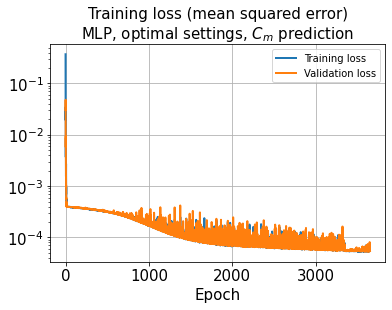

In [44]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

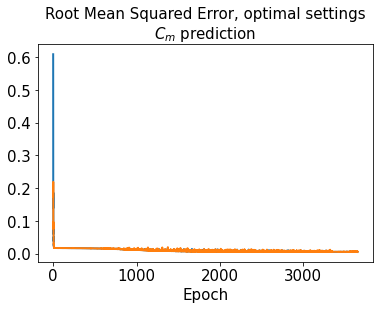

In [45]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

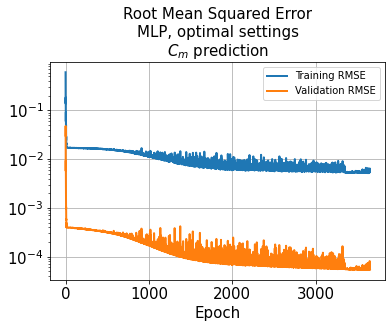

In [46]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [47]:
train_results = model.evaluate(x_train, y_train)

219/219 [==============================] - 1s 4ms/step - loss: 5.3787e-05 - rmse: 0.0053


In [48]:
val_results = model.evaluate(x_val, y_val)

63/63 [==============================] - 0s 3ms/step - loss: 5.4334e-05 - rmse: 0.0053


In [49]:
test_results = model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 5.4091e-05 - rmse: 0.0053


In [50]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

32/32 [==============================] - 0s 1ms/step


In [51]:
decoded_train_

array([[0.9660619 ],
       [0.9666672 ],
       [0.9676097 ],
       ...,
       [0.96518975],
       [0.9686297 ],
       [0.96736836]], dtype=float32)

In [52]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [53]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [54]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [55]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [56]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [57]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [58]:
model_directory = "D:\\TrainedModels\\20221228"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221227unsteadyValidation_Case01MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [59]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [60]:
os.chdir(storage_dir)

In [61]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [118]:
max(decoded_train)

array([0.1970216], dtype=float32)

In [119]:
max(y_train)

array([0.19709169])

In [62]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.006276569389033808
0.2352921088675442


In [94]:
max(y_train)

array([0.19709169])

In [63]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.006335233191786564
0.23840358042831664


In [64]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.0063108646432795705
0.23816385727733422


In [65]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [66]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [67]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [68]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [69]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [70]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [71]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

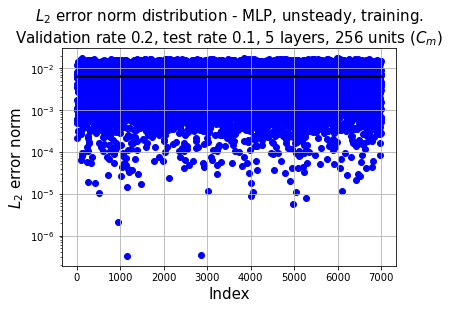

In [72]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

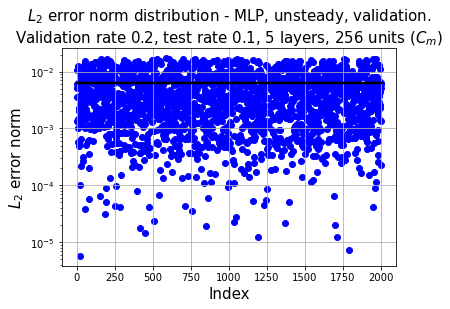

In [73]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

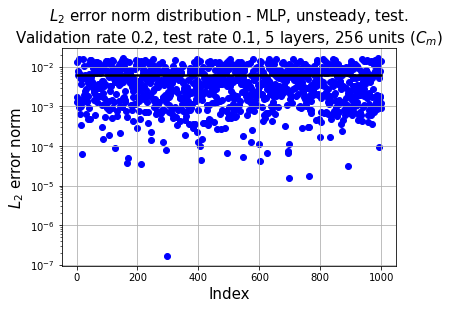

In [74]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [113]:
predicted = model.predict(x)

313/313 [==============================] - 1s 2ms/step


In [134]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [78]:
index_train.shape

(6999,)

In [120]:
y = denormalize(y)

In [124]:
l2_error(denormalize(predicted), y)

0.6155187081827621

In [135]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [136]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [86]:
x += 10

In [137]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.6068


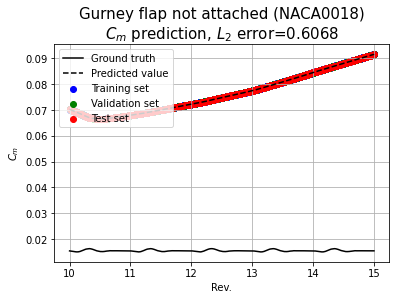

L2 error of Cm: 0.6242


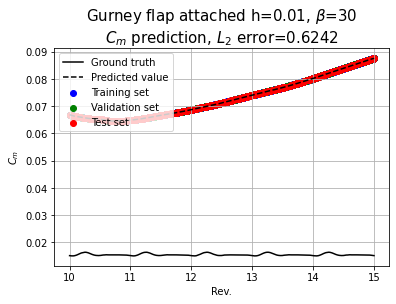

In [138]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0,2):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((denormalize(predictedValue) - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [89]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.0056


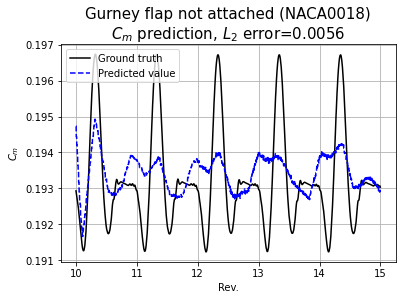

L2 error of Cm: 0.0054


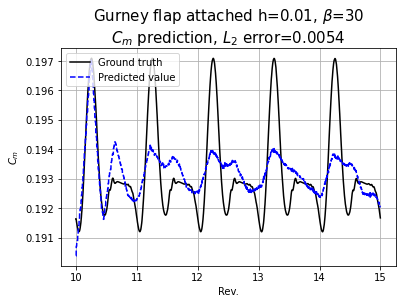

C:\Users\cfdML\AppData\Local\Temp\ipykernel_26152\3766457437.py:15: RuntimeWarning: invalid value encountered in double_scalars
  l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))


L2 error of Cm: nan


ValueError: x and y must have same first dimension, but have shapes (5000, 1) and (0, 1)

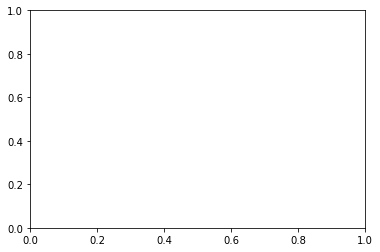

In [90]:
for i in range(0,15):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
# 